In [1]:
import glob, os, sys
sys.path.append("..")
from utils.utils import *
import uproot, ROOT, random, time, vector
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import json
from sklearn.metrics import roc_curve, roc_auc_score, auc
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from xgboost import XGBClassifier 
import shap

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer


# mpl.rcParams['figure.figsize'] = 12.0,8.0  # Roughly 11 cm wde by 8 cm high
# mpl.rcParams['font.size'] = 14.0 # Use 14 point font
# sns.set(style="whitegrid")

Welcome to JupyROOT 6.30/04


/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/ROOT/_facade.py:154: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  return _orig_ihook(name, *args, **kwds)


In [2]:
Ztt_inc = [
    # mc23 DSIDs
    # 700621, 700622, 700623, 
    # 700642, 700643, 700644,
    # 700703, 700704, 700705,
    # mc20 DSIDs
    700792, 700793, 700794,
    700360, # Ztautau2jets
    ]

ttV = [
    410155, # ttW
    # 410218, 410219, 410220, # ttZ
    304014, # 3t, 4t #! missing these samples
    ]

# Diboson
VV = [
    700488, 700489, 
    700491, 700492, 700493, 700494, 700495, 700496,
    700600, 700601, 700602, 700603, 700604, 700605, 
]

# Single-Top and ttbar (new samples now!)
Top = [
    410470, 410471, 
    # 410472, 
    410644, 410645, 410646, 410647, 
    410658, 410659
]

# W(tau/mu/e + nu) + jets
W = [
    700338, 700339, 700340, # Wenu
    700341, 700342, 700343, # Wmunu #! 700342 is missing (should be okay... basically no W)
    700344, 700345, 700346, # WtaunuL
    700347, 700348, 700349, # WtaunuH #! should these be included? are these signal?
    700362, 700363, 700364, # W lep + 2jets
]

Zll_inc = [
    700320, 700321, 700322, # Zee 
    700323, 700324, 700325, # Zmumu
    700358, #Zee2jets
    700359, #Zmumu2jets
]

Zee = [
    700320, 700321, 700322, # Zee
    700358, # Zee2jets
]

Zmumu = [
    700323, 700324, 700325, # Zmumu
    700359, # Zmumu2jetss
]

# Signal samples (new)
ggH = [
    345120, 345121, 345122, 345123
    ]
VBFH = [
    # mc20 DSIDs
    346190, 346191, 346192, 346193,
]
WH = [345211, 345212]
ZH = [345217]
ttH = [346343,346344,346345]

LUMI = {
    '15': 3244.54,
    '16': 33402.2,
    '17': 44630.6,
    '18': 58791.6,    
}

LUMI_SCALE = {
    '15': (3244.54+33402.2)/3244.54,
    '16': (3244.54+33402.2)/33402.2,
    '17': 1,
    '18': 1,
}

In [3]:
def read_event_weights(event_id, data_year):
    file_path = './xsec_sumofweights_nom_old_V08.json'
    # Load the data from the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Get the list of events from the key 'ditau_hh' under 'mc20a'
    events = data.get(data_year, {}).get('ditau_hh', [])

    # Iterate over each event in the list
    for event in events:
        # Check if the first element (ID) matches the provided event_id
        if event[0] == event_id:
            # Return the second (event weight) and third (sum of event weights) elements
            return (event[1], event[2])
    
    # If no matching ID is found, return None for both values
    return (None, None)

def fetch_weights(id_list, data_year):
    results = {}
    for event_id in id_list:
        event_weight, sum_event_weights = read_event_weights(event_id, data_year)
        if event_weight is None:
            print(event_id, "weights filled with one")
            results[event_id] = 1
        else: 
            results[event_id] = event_weight / sum_event_weights
    return results
            
#signal
vbfh_ws_e = fetch_weights(VBFH, 'mc20e')
ggh_ws_e = fetch_weights(ggH, 'mc20e')
wh_ws_e = fetch_weights(WH, 'mc20e')
zh_ws_e = fetch_weights(ZH, 'mc20e')
tth_ws_e = fetch_weights(ttH, 'mc20e')
#background
ztt_ws_e = fetch_weights(Ztt_inc, 'mc20e')
ttv_ws_e = fetch_weights(ttV, 'mc20e')
vv_ws_e = fetch_weights(VV, 'mc20e')
top_ws_e = fetch_weights(Top, 'mc20e')
w_ws_e = fetch_weights(W, 'mc20e')
zll_ws_e = fetch_weights(Zll_inc, 'mc20e')

In [4]:
vbfh_ws_e

{346190: 2.5967210059187122e-09,
 346191: 7.31710215762491e-09,
 346192: 7.336280155766438e-09,
 346193: 8.901021803205183e-09}

In [5]:
vbfh_ws_d = fetch_weights(VBFH, 'mc20d')
ggh_ws_d = fetch_weights(ggH, 'mc20d')
wh_ws_d = fetch_weights(WH, 'mc20d')
zh_ws_d = fetch_weights(ZH, 'mc20d')
tth_ws_d = fetch_weights(ttH, 'mc20d')
ztt_ws_d = fetch_weights(Ztt_inc, 'mc20d')
ttv_ws_d = fetch_weights(ttV, 'mc20d')
vv_ws_d = fetch_weights(VV, 'mc20d')
top_ws_d = fetch_weights(Top, 'mc20d')
w_ws_d = fetch_weights(W, 'mc20d')
zll_ws_d = fetch_weights(Zll_inc, 'mc20d')

vbfh_ws_a = fetch_weights(VBFH, 'mc20a')
ggh_ws_a = fetch_weights(ggH, 'mc20a')
wh_ws_a = fetch_weights(WH, 'mc20a')
zh_ws_a = fetch_weights(ZH, 'mc20a')
tth_ws_a = fetch_weights(ttH, 'mc20a')
ztt_ws_a = fetch_weights(Ztt_inc, 'mc20a')
ttv_ws_a = fetch_weights(ttV, 'mc20a')
vv_ws_a = fetch_weights(VV, 'mc20a')
top_ws_a = fetch_weights(Top, 'mc20a')
w_ws_a = fetch_weights(W, 'mc20a')
zll_ws_a = fetch_weights(Zll_inc, 'mc20a')

In [6]:
branches = \
[
'ditau_obj_truth_leadTau_p4',
'ditau_obj_truth_subleadTau_p4',
'boson_0_classifierParticleOrigin',
'boson_0_mother_pdgId',
'boson_0_mother_status',
'boson_0_pdgId',
'boson_0_truth_pdgId',
'boson_0_truth_q',
'boson_0_truth_status',
'boson_0_q',
'ditau_obj_IsTruthMatched',
'ditau_obj_IsTruthHadronic',
'ditau_obj_truth_p4',
'met_truth_p4',

#  'mlp_scores',
 'NOMINAL_pileup_random_run_number',
 'ditau_obj_bdt_score',
#  'ditau_obj_charge',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
#  'ditau_obj_n_iso_tracks',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
#  'ditau_obj_subjets_dR',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'event_number',
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'NOMINAL_pileup_combined_weight',
 'n_bjets_DL1dv01_FixedCutBEff_70',
 'weight_mc']

data_branches = \
[
#  'mlp_scores',
 'event_number',    
 'met_p4',
 'met_sumet',
 'met_hpto_p4',
 'event_is_bad_batman',
 'ditau_obj_bdt_score',
 'ditau_obj_leadsubjet_charge',
 'ditau_obj_leadsubjet_n_core_tracks',
 'ditau_obj_leadsubjet_p4',
 'ditau_obj_nSubjets',
 'ditau_obj_n_tracks',
 'ditau_obj_p4',
 'ditau_obj_subleadsubjet_charge',
 'ditau_obj_subleadsubjet_n_core_tracks',
 'ditau_obj_subleadsubjet_p4',
 'n_bjets_DL1dv01_FixedCutBEff_70']

In [7]:
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'
# path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/mc/ditau_hh/mc20e/nom/user.shhirose.*{dsid}.*/user.*.root'
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/mc/ditau_hh/{year}/nom/user.shhirose.*{dsid}.*/user.*.root'

def read_root(dsid_list, mc_ws, year_id='mc20e', year='18'):
    out = []
    hlt_branches = {
        '15': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '16': ['HLT_j360', 'HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'],
        '17': ['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'],
        '18': ['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    }
    
    for dsid in dsid_list:
        # Using wildcard pattern around the DSID
        file_pattern = path_template.format(dsid=dsid, year=year_id)
        files = glob.glob(file_pattern)
        s = time.time()
        
        for file in files:
            with uproot.open(file + ':NOMINAL') as f_1:
                branches_read = branches + hlt_branches.get(year, [])
                events = f_1.arrays(branches_read, library='ak')

                # Handling 2015 and 2016 conditions
                if year in ['15', '16']:
                    mask_15 = (events['NOMINAL_pileup_random_run_number'] <= 284484) & (events['NOMINAL_pileup_random_run_number'] > 0)
                    mask_16 = (events['NOMINAL_pileup_random_run_number'] > 284484) & (events['NOMINAL_pileup_random_run_number'] <= 311563)

                    events['weight'] = mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks']) * events['weight_mc'] * events['NOMINAL_pileup_combined_weight']

                    # Assign weights based on the run number
                    events['weight'] = ak.where(mask_15,
                                                events['weight'] * LUMI_SCALE['15'] * LUMI['15'],
                                                ak.where(mask_16,
                                                         events['weight'] * LUMI_SCALE['16'] * LUMI['16'],
                                                         events['weight']))
                    
                    if not ak.any(mask_15 | mask_16):
                        print(f"Event number out of range in file: {file}")
                
                elif year in ['17', '18']:
                    events['weight'] = (mc_ws[dsid] * ak.ones_like(events['ditau_obj_n_tracks'])) * \
                                       events['weight_mc'] * events['NOMINAL_pileup_combined_weight'] * \
                                       LUMI_SCALE[year] * LUMI[year]
                
                out = ak.concatenate((out, events))

        print(f"Processed year: {year}, files for DSID {dsid_list}, Time spent: {round(time.time()-s, 4)} s")
    
    return out


vbfh_e = read_root(VBFH, vbfh_ws_e, year_id='mc20e', year='18')
ggh_e = read_root(ggH, ggh_ws_e, year_id='mc20e', year='18')
wh_e = read_root(WH, wh_ws_e, year_id='mc20e', year='18')
zh_e = read_root(ZH, zh_ws_e, year_id='mc20e', year='18')
tth_e = read_root(ttH, tth_ws_e, year_id='mc20e', year='18')
ztt_e = read_root(Ztt_inc, ztt_ws_e, year_id='mc20e', year='18')
ttv_e = read_root(ttV, ttv_ws_e, year_id='mc20e', year='18')
vv_e = read_root(VV, vv_ws_e, year_id='mc20e', year='18')
top_e = read_root(Top, top_ws_e, year_id='mc20e', year='18')
w_e = read_root(W, w_ws_e, year_id='mc20e', year='18')
zll_e = read_root(Zll_inc, zll_ws_e, year_id='mc20e', year='18')

vbfh_d = read_root(VBFH, vbfh_ws_d, year_id='mc20d', year='17')
ggh_d = read_root(ggH, ggh_ws_d, year_id='mc20d', year='17')
wh_d = read_root(WH, wh_ws_d, year_id='mc20d', year='17')
zh_d = read_root(ZH, zh_ws_d, year_id='mc20d', year='17')
tth_d = read_root(ttH, tth_ws_d, year_id='mc20d', year='17')
ztt_d = read_root(Ztt_inc, ztt_ws_d, year_id='mc20d', year='17')
ttv_d = read_root(ttV, ttv_ws_d, year_id='mc20d', year='17')
vv_d = read_root(VV, vv_ws_d, year_id='mc20d', year='17')
top_d = read_root(Top, top_ws_d, year_id='mc20d', year='17')
w_d = read_root(W, w_ws_d, year_id='mc20d', year='17')
zll_d = read_root(Zll_inc, zll_ws_d, year_id='mc20d', year='17')

vbfh_a = read_root(VBFH, vbfh_ws_a, year_id='mc20a', year='15')
ggh_a = read_root(ggH, ggh_ws_a, year_id='mc20a', year='15')
wh_a = read_root(WH, wh_ws_a, year_id='mc20a', year='15')
zh_a = read_root(ZH, zh_ws_a, year_id='mc20a', year='15')
tth_a = read_root(ttH, tth_ws_a, year_id='mc20a', year='15')
ztt_a = read_root(Ztt_inc, ztt_ws_a, year_id='mc20a', year='15')
ttv_a = read_root(ttV, ttv_ws_a, year_id='mc20a', year='15')
vv_a = read_root(VV, vv_ws_a, year_id='mc20a', year='15')
top_a = read_root(Top, top_ws_a, year_id='mc20a', year='15')
w_a = read_root(W, w_ws_a, year_id='mc20a', year='15')
zll_a = read_root(Zll_inc, zll_ws_a, year_id='mc20a', year='15')


Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.2047 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.1942 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.3639 s
Processed year: 18, files for DSID [346190, 346191, 346192, 346193], Time spent: 0.4127 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.949 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.4051 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.3806 s
Processed year: 18, files for DSID [345120, 345121, 345122, 345123], Time spent: 0.5497 s
Processed year: 18, files for DSID [345211, 345212], Time spent: 0.4279 s
Processed year: 18, files for DSID [345211, 345212], Time spent: 0.2035 s
Processed year: 18, files for DSID [345217], Time spent: 0.2058 s
Processed year: 18, files for DSID [346343, 346344, 346345], Time s

In [8]:
## load data
# path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data{year}/user.shhirose.Httbst*/*.root'

def read_data_root(year='18'):
    file_paths = path_template_data.format(year=year)
    out = []
    l1 = glob.glob(file_paths)
    s = time.time()
    for i in range(len(l1)):
        f_1 = uproot.open(l1[i]+':NOMINAL')
        #if file is empty skip
        if f_1.num_entries == 0:
            continue
        branches_read = []
        branches_read.extend(data_branches)
        if year == '15':
            branches_read.extend(['HLT_j360'])
        elif year == '16':
            branches_read.extend(['HLT_j380', 'HLT_j420_a10_lcw_L1J100', 'HLT_j420_a10r_L1J100'])
        elif year == '17':
            branches_read.extend(['HLT_j400', 'HLT_j440_a10_lcw_subjes_L1J100'])
        elif year == '18':
            branches_read.extend(['HLT_j420', 'HLT_j420_a10t_lcw_jes_35smcINF_L1J100', 'HLT_j420_a10t_lcw_jes_35smcINF_L1SC111'])
        events = f_1.arrays(branches_read, library='ak')
        out = ak.concatenate((events, out))
    print("processed: ", l1, "time spent", round(time.time()-s, 4), 's')
    return out

data_18 = read_data_root(year='18')
data_17 = read_data_root(year='17')
data_16 = read_data_root(year='16')
data_15 = read_data_root(year='15')

processed:  ['/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000122.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000004.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000380.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data18/user.shhirose.Httbst_b8.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p6266.smPre_w_0_HS/user.shhirose.40642374._000279.HSM_boostedDiTau.root', '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/dita

In [8]:
# def Cut(t):
#     cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
#                    (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & #b veto
#                    (t['ditau_obj_IsTruthMatched']==1) &
#                    (t['ditau_obj_bdt_score'] >= 0.72) &
#                 #    (t['event_is_bad_batman'] == 0) &
#                    (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
#                    (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & ### last 2 cuts are in ntuples now
#                    (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
#                    (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
#                    ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
#     return t[cut]

# def data_Cut(t):
#     cut = ak.where((t['ditau_obj_nSubjets'] >= 2) &
#                    (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) &
#                    (t['ditau_obj_bdt_score'] < 0.72) &
#                    (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) &
#                    (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) &
#                    (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) &
#                    (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) &
#                    ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))
#     return t[cut]



In [10]:
def data_Cut(t, year):
    # Define HLT conditions based on the year
    if year == '15':
        hlt_cut = t['HLT_j360']
    elif year == '16':
        hlt_cut = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']
    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']
    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")
    
    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_bdt_score'] < 0.9) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)

    return t[final_cut]

def mc_Cut(t, year):
    # Define HLT conditions based on the year and run number for 2015 and 2016
    if year == '15' or year == '16':
        mask_15 = (t['NOMINAL_pileup_random_run_number'] <= 284484) & (t['NOMINAL_pileup_random_run_number'] > 0)
        mask_16 = (t['NOMINAL_pileup_random_run_number'] > 284484) & (t['NOMINAL_pileup_random_run_number'] <= 311563)

        hlt_cut_15 = t['HLT_j360']
        hlt_cut_16 = t['HLT_j380'] | t['HLT_j420_a10_lcw_L1J100'] | t['HLT_j420_a10r_L1J100']

        hlt_cut = (mask_15 & hlt_cut_15) | (mask_16 & hlt_cut_16)

    elif year == '17':
        hlt_cut = t['HLT_j400'] | t['HLT_j440_a10_lcw_subjes_L1J100']

    elif year == '18':
        hlt_cut = t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']
    else:
        raise ValueError(f"Unsupported year: {year}")

    general_cut = ((t['ditau_obj_nSubjets'] >= 2) & \
               (((t['ditau_obj_leadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_leadsubjet_n_core_tracks'] == 3)) & 
                ((t['ditau_obj_subleadsubjet_n_core_tracks'] == 1) | (t['ditau_obj_subleadsubjet_n_core_tracks'] == 3))) & \
               (t['ditau_obj_IsTruthMatched']==1) & \
               (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & \
               (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & \
               (t['ditau_obj_bdt_score'] >= 0.9) & \
               (t['ditau_obj_n_tracks'] - t['ditau_obj_leadsubjet_n_core_tracks'] - t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))

    # Combine HLT-specific cuts with general cuts
    final_cut = ak.where(general_cut & (hlt_cut))
    # final_cut = ak.where(general_cut)


    return t[final_cut]


In [11]:
vbfh_e_cut = mc_Cut(vbfh_e, '18')
ggh_e_cut = mc_Cut(ggh_e, '18')
wh_e_cut = mc_Cut(wh_e, '18')
zh_e_cut = mc_Cut(zh_e, '18')
tth_e_cut = mc_Cut(tth_e, '18')
ztt_e_cut = mc_Cut(ztt_e, '18')
ttv_e_cut = mc_Cut(ttv_e, '18')
vv_e_cut = mc_Cut(vv_e, '18')
top_e_cut = mc_Cut(top_e, '18')
w_e_cut = mc_Cut(w_e, '18')
zll_e_cut = mc_Cut(zll_e, '18')

vbfh_d_cut = mc_Cut(vbfh_d, '17')
ggh_d_cut = mc_Cut(ggh_d, '17')
wh_d_cut = mc_Cut(wh_d, '17')
zh_d_cut = mc_Cut(zh_d, '17')
tth_d_cut = mc_Cut(tth_d, '17')
ztt_d_cut = mc_Cut(ztt_d, '17')
ttv_d_cut = mc_Cut(ttv_d, '17')
vv_d_cut = mc_Cut(vv_d, '17')
top_d_cut = mc_Cut(top_d, '17')
w_d_cut = mc_Cut(w_d, '17')
zll_d_cut = mc_Cut(zll_d, '17')

vbfh_a_cut = mc_Cut(vbfh_a, '15')
ggh_a_cut = mc_Cut(ggh_a, '15')
wh_a_cut = mc_Cut(wh_a, '15')
zh_a_cut = mc_Cut(zh_a, '15')
tth_a_cut = mc_Cut(tth_a, '15')
ztt_a_cut = mc_Cut(ztt_a, '15')
ttv_a_cut = mc_Cut(ttv_a, '15')
vv_a_cut = mc_Cut(vv_a, '15')
top_a_cut = mc_Cut(top_a, '15')
w_a_cut = mc_Cut(w_a, '15')
zll_a_cut = mc_Cut(zll_a, '15')

data_18_cut = data_Cut(data_18, '18')
data_17_cut = data_Cut(data_17, '17')
data_16_cut = data_Cut(data_16, '16')
data_15_cut = data_Cut(data_15, '15')




In [12]:
#combine all mc the samples
vbfh_cut = ak.concatenate([vbfh_e_cut, vbfh_d_cut, vbfh_a_cut])
ggh_cut = ak.concatenate([ggh_e_cut, ggh_d_cut, ggh_a_cut])
wh_cut = ak.concatenate([wh_e_cut, wh_d_cut, wh_a_cut])
zh_cut = ak.concatenate([zh_e_cut, zh_d_cut, zh_a_cut])
tth_cut = ak.concatenate([tth_e_cut, tth_d_cut, tth_a_cut])
ztt_cut = ak.concatenate([ztt_e_cut, ztt_d_cut, ztt_a_cut])
ttv_cut = ak.concatenate([ttv_e_cut, ttv_d_cut, ttv_a_cut])
vv_cut = ak.concatenate([vv_e_cut, vv_d_cut, vv_a_cut])
top_cut = ak.concatenate([top_e_cut, top_d_cut, top_a_cut])
w_cut = ak.concatenate([w_e_cut, w_d_cut, w_a_cut])
zll_cut = ak.concatenate([zll_e_cut, zll_d_cut, zll_a_cut])

#combine all data samples
data_cut = ak.concatenate([data_18_cut, data_17_cut, data_16_cut, data_15_cut])


In [13]:
len(data_cut['ditau_obj_bdt_score'])

201088

vbfh_SR_truth_ratio: 0.9277 ± 0.0036
vbfh_CR_truth_ratio: 0.9024 ± 0.0106
ggh_SR_truth_ratio: 0.9528 ± 0.0034
ggh_CR_truth_ratio: 0.9383 ± 0.0092
wh_SR_truth_ratio: 0.9257 ± 0.0114
wh_CR_truth_ratio: 0.8305 ± 0.0345
zh_SR_truth_ratio: 0.9313 ± 0.0111
zh_CR_truth_ratio: 0.9018 ± 0.0281
tth_SR_truth_ratio: 0.8796 ± 0.0172
tth_CR_truth_ratio: 0.6328 ± 0.0426
ztt_SR_truth_ratio: 0.8744 ± 0.0004
ztt_CR_truth_ratio: 0.8131 ± 0.0008
ttv_SR_truth_ratio: 0.0000 ± 0.0000
ttv_CR_truth_ratio: 0.0000 ± 0.0000
vv_SR_truth_ratio: 0.7408 ± 0.0024
vv_CR_truth_ratio: 0.7680 ± 0.0041
top_SR_truth_ratio: 0.0880 ± 0.0253
top_CR_truth_ratio: 0.0614 ± 0.0140
w_SR_truth_ratio: 0.0051 ± 0.0036
w_CR_truth_ratio: 0.0008 ± 0.0008
zll_SR_truth_ratio: 0.0000 ± 0.0000
zll_CR_truth_ratio: 0.0000 ± 0.0000


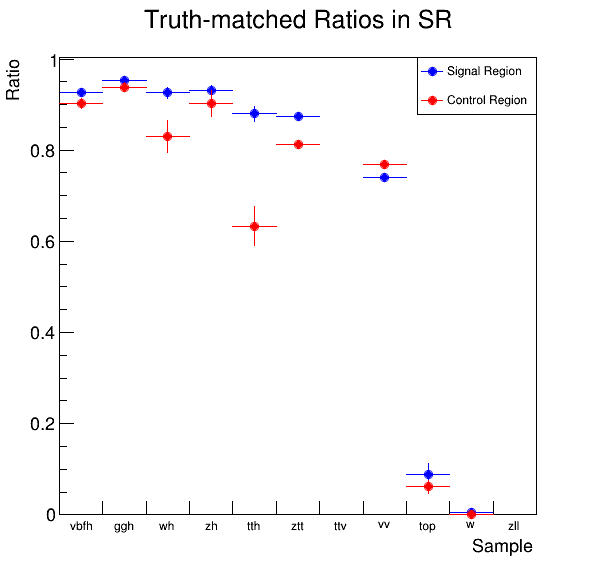

In [12]:
ROOT.gStyle.SetOptStat(0)

def check_truth_matched_SR_CR(sample):
    sample_SR = sample[(sample['ditau_obj_bdt_score'] >= 0.96)]
    sample_CR = sample[(sample['ditau_obj_bdt_score'] < 0.96)]
    
    sample_SR_truth_matched = ak.sum(sample_SR['ditau_obj_IsTruthHadronic'])
    # sample_SR_total = len(sample_SR) - sample_SR_truth_matched
    sample_SR_total = len(sample_SR)


    sample_CR_truth_matched = ak.sum(sample_CR['ditau_obj_IsTruthHadronic'])
    sample_CR_total = len(sample_CR) 
    # sample_CR_total = len(sample_CR) - sample_CR_truth_matched


    return sample_SR_truth_matched, sample_SR_total, sample_CR_truth_matched, sample_CR_total

# List of sample names and their corresponding variables
samples = [
    ("vbfh", vbfh_cut),
    ("ggh", ggh_cut),
    ("wh", wh_cut),
    ("zh", zh_cut),
    ("tth", tth_cut),
    ("ztt", ztt_cut),
    ("ttv", ttv_cut),
    ("vv", vv_cut),
    ("top", top_cut),
    ("w", w_cut),
    ("zll", zll_cut)
]

# Create ROOT histograms
h_SR_num = ROOT.TH1F("h_SR_num", "Truth-matched in SR", len(samples), 0, len(samples))
h_SR_den = ROOT.TH1F("h_SR_den", "Total in SR", len(samples), 0, len(samples))
h_CR_num = ROOT.TH1F("h_CR_num", "Truth-matched in CR", len(samples), 0, len(samples))
h_CR_den = ROOT.TH1F("h_CR_den", "Total in CR", len(samples), 0, len(samples))

# Fill histograms
for i, (name, sample) in enumerate(samples, 1):
    SR_matched, SR_total, CR_matched, CR_total = check_truth_matched_SR_CR(sample)
    
    h_SR_num.SetBinContent(i, SR_matched)
    h_SR_den.SetBinContent(i, SR_total)
    h_CR_num.SetBinContent(i, CR_matched)
    h_CR_den.SetBinContent(i, CR_total)
    
    h_SR_num.GetXaxis().SetBinLabel(i, name)
    h_SR_den.GetXaxis().SetBinLabel(i, name)
    h_CR_num.GetXaxis().SetBinLabel(i, name)
    h_CR_den.GetXaxis().SetBinLabel(i, name)

# Create ratio histograms
h_SR_ratio = h_SR_num.Clone("h_SR_ratio")
h_SR_ratio.SetTitle("Truth-matched Ratios in SR;Sample;Ratio")
h_SR_ratio.Divide(h_SR_num, h_SR_den, 1., 1., "B")

h_CR_ratio = h_CR_num.Clone("h_CR_ratio")
h_CR_ratio.SetTitle("Truth-matched Ratios in CR;Sample;Ratio")
h_CR_ratio.Divide(h_CR_num, h_CR_den, 1., 1., "B")

# Create canvas and draw histograms
c = ROOT.TCanvas("c", "Truth-matched Ratios", 600, 600)
# c.Divide(2, 1)

c.cd()
h_SR_ratio.SetMarkerStyle(20)
h_SR_ratio.SetMarkerColor(ROOT.kBlue)
h_SR_ratio.SetLineColor(ROOT.kBlue)
h_SR_ratio.Draw("")
# h_SR_ratio.GetYaxis().SetRangeUser(0, 23)

# c.cd(2)
h_CR_ratio.SetMarkerStyle(20)
h_CR_ratio.SetMarkerColor(ROOT.kRed)
h_CR_ratio.SetLineColor(ROOT.kRed)
h_CR_ratio.Draw("same")
# h_CR_ratio.GetYaxis().SetRangeUser(0, 20)

# Add legend
# legend_SR = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
# legend_SR.Draw()

legend_CR = ROOT.TLegend(0.7, 0.8, 0.9, 0.9)
legend_CR.AddEntry(h_SR_ratio, "Signal Region")
legend_CR.AddEntry(h_CR_ratio, "Control Region", )
legend_CR.Draw()

# Print ratios and errors
for i in range(1, len(samples) + 1):
    name = h_SR_ratio.GetXaxis().GetBinLabel(i)
    sr_ratio = h_SR_ratio.GetBinContent(i)
    sr_error = h_SR_ratio.GetBinError(i)
    cr_ratio = h_CR_ratio.GetBinContent(i)
    cr_error = h_CR_ratio.GetBinError(i)
    print(f"{name}_SR_truth_ratio: {sr_ratio:.4f} ± {sr_error:.4f}")
    print(f"{name}_CR_truth_ratio: {cr_ratio:.4f} ± {cr_error:.4f}")

# Save the canvas
# c.SaveAs("truth_matched_ratios.png")
c.Draw()

In [12]:
# #print number of events after each cut for all samples
# #first make a fucntion to print the number of events after each cut
# def Printcut(t):
#     # print skip line for each sample
#     # print("  ", end='\n')
#     print(len((t['ditau_obj_nSubjets'])), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0))[0]), end=' & ')
#     print(len(ak.where((t['ditau_obj_nSubjets'] >= 2) & (t['n_bjets_DL1dv01_FixedCutBEff_70'] == 0) & (t['ditau_obj_IsTruthMatched']==1) & (t['ditau_obj_bdt_score'] >= 0.72) & (t['event_is_bad_batman'] == 0) & (t['HLT_j420'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1J100'] | t['HLT_j420_a10t_lcw_jes_35smcINF_L1SC111']) & (t['ditau_obj_leadsubjet_charge'] * t['ditau_obj_subleadsubjet_charge'] == -1) & (t['ditau_obj_n_tracks']-t['ditau_obj_leadsubjet_n_core_tracks']-t['ditau_obj_subleadsubjet_n_core_tracks'] == 0) & (((t['ditau_obj_leadsubjet_n_core_tracks']==1) | (t['ditau_obj_leadsubjet_n_core_tracks']==3)) & ((t['ditau_obj_subleadsubjet_n_core_tracks']==1) | (t['ditau_obj_subleadsubjet_n_core_tracks']==3))))[0]))


# Printcut(ggh)
# Printcut(vbfh)
# Printcut(wh)
# Printcut(zh)
# Printcut(tth)

In [13]:
###slower code for collieanr mass calc####
# def collinear_mass_calc(k1, k2, metetx, metety):
#     collinear_mass = []
#     for i in range(len(metetx)):
#         k1_sub = vector.obj(px=k1.px[i], py=k1.py[i], pz=k1.pz[i], energy=k1.energy[i])
#         k2_sub = vector.obj(px=k2.px[i], py=k2.py[i], pz=k2.pz[i], energy=k2.energy[i])
#         K = np.array([[k1_sub.px, k2_sub.px],
#                       [k1_sub.py, k2_sub.py]])
#         if np.linalg.det(K) == 0:
#            return -1
#         M = np.array([[metetx[i]],
#                       [metety[i]]])
#         Kinv = np.linalg.inv(K)
#         X = np.dot(Kinv, M)
#         X1 = X[0, 0]
#         X2 = X[1, 0]
#         x1 = 1. / (1. + X1)
#         x2 = 1. / (1. + X2)
#         p1 = k1_sub * (1 / x1)
#         p2 = k2_sub * (1 / x2)
#         collinear_mass.append((p1 + p2).mass)

#     return collinear_mass

In [14]:
def collinear_mass_calc(k1, k2, metetx, metety):
    k1_px = np.array(k1.px)
    k1_py = np.array(k1.py)
    k1_pz = np.array(k1.pz)
    k1_energy = np.array(k1.energy)
    
    k2_px = np.array(k2.px)
    k2_py = np.array(k2.py)
    k2_pz = np.array(k2.pz)
    k2_energy = np.array(k2.energy)
    
    metetx = np.array(metetx)
    metety = np.array(metety)

    collinear_mass = []
    x1_out = []
    x2_out = []
    
    for i in range(len(metetx)):
        K = np.array([[k1_px[i], k2_px[i]],
                      [k1_py[i], k2_py[i]]])
        if np.linalg.det(K) == 0:
            print("WARNING: Singular matrix")
            return 0
        M = np.array([[metetx[i]],
                      [metety[i]]])
        
        Kinv = np.linalg.inv(K)
        X = np.dot(Kinv, M)
        X1 = X[0, 0]
        X2 = X[1, 0]
        
        x1 = 1. / (1. + X1)
        x2 = 1. / (1. + X2)
        
        p1 = vector.obj(px=k1_px[i], py=k1_py[i], pz=k1_pz[i], energy=k1_energy[i]) * (1 / x1)
        p2 = vector.obj(px=k2_px[i], py=k2_py[i], pz=k2_pz[i], energy=k2_energy[i]) * (1 / x2)
        
        collinear_mass.append((p1 + p2).mass)
        x1_out.append(x1)
        x2_out.append(x2)
    
    return collinear_mass, x1_out, x2_out


In [15]:
# def collinear_mass_calc(k1_px, k1_py, k1_pz, k1_energy, k2_px, k2_py, k2_pz, k2_energy, metetx, metety):
#     collinear_mass = []

#     K = np.array([[k1_px, k2_px],
#                   [k1_py, k2_py]])
#     if np.linalg.det(K) == 0:
#         print("AAAAAA")
#         return 0
#     M = np.array([[metetx],
#                   [metety]])
    
#     Kinv = np.linalg.inv(K)
#     X = np.dot(Kinv, M)
#     X1 = X[0, 0]
#     X2 = X[1, 0]
    
#     x1 = 1. / (1. + X1)
#     x2 = 1. / (1. + X2)
    
#     p1 = vector.obj(px=k1_px, py=k1_py, pz=k1_pz, energy=k1_energy) * (1 / x1)
#     p2 = vector.obj(px=k2_px, py=k2_py, pz=k2_pz, energy=k2_energy) * (1 / x2)
    
#     collinear_mass.append((p1 + p2).mass)
    
#     return collinear_mass

# collinear_mass_calc(-0.989992, 0.14112, 3.62686, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)
# collinear_mass_calc(17.2739, 33.2716 , 38.9482, 4, 3.76951, 3.28493, 1008.57, 8, 9, 10)


In [16]:
ff_scale = 1

def determine_prong(leadNTracks, subleadNTracks):
    if leadNTracks == 1 and subleadNTracks == 1:
        return 1
    elif leadNTracks == 3 and subleadNTracks == 1:
        return 2
    elif leadNTracks == 1 and subleadNTracks == 3:
        return 2
    elif leadNTracks == 3 and subleadNTracks == 3:
        return 3
    else:
        return -1

def load_histograms(root_file):
    file = uproot.open(root_file)
    histograms = {
        "h_ff_1p1p": file["FF_1p1p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_1p3p": file["FF_1p3p_ditau_obj_subleadsubjet_pt"].to_hist(),
        "h_ff_3p3p": file["FF_3p3p_ditau_obj_subleadsubjet_pt"].to_hist()
    }
    return histograms

def fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms):
    weights = []
    
    for lead, sublead, lead_pt, sublead_pt in zip(leadNTracks, subleadNTracks, lead_pt, sublead_pt):
        prongness = determine_prong(lead, sublead)
        weight = 0
        
        if prongness == 1:
            bin_idx = histograms["h_ff_1p1p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p1p"].values()[bin_idx]
        elif prongness == 2:
            bin_idx = histograms["h_ff_1p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_1p3p"].values()[bin_idx]
        elif prongness == 3:
            bin_idx = histograms["h_ff_3p3p"].axes[0].index(sublead_pt)
            weight = histograms["h_ff_3p3p"].values()[bin_idx]
        else:
            weight = -1
        
        weights.append(weight)
    
    return [w * ff_scale for w in weights]


In [17]:
# def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
#     d = np.sin(sublead_jet_phi - lead_jet_phi)
#     centrality = []
#     for i in range(len(d)):
#         if d[i] == 0:
#             centrality.append(-1234)
#         else:
#             #A = np.sin(met_phi - lead_jet_phi) / d
#             #B = np.sin(sublead_jet_phi - met_phi) / d
#             A = np.sin(met_phi[i] - lead_jet_phi[i]) / d[i]
#             B = np.sin(sublead_jet_phi[i] - met_phi[i]) / d[i]
#             centrality.append((A + B) / np.sqrt(A * A + B * B))
#     return centrality

def met_centrality(lead_jet_phi, sublead_jet_phi, met_phi):
    # Convert Awkward Arrays to NumPy for calculation
    lead_jet_phi_np = ak.to_numpy(lead_jet_phi)
    sublead_jet_phi_np = ak.to_numpy(sublead_jet_phi)
    met_phi_np = ak.to_numpy(met_phi)
    
    d = np.sin(sublead_jet_phi_np - lead_jet_phi_np)
    centrality = np.full_like(d, -1234.0)
    valid_indices = np.where(d != 0)
    
    A = np.sin(met_phi_np[valid_indices] - lead_jet_phi_np[valid_indices]) / d[valid_indices]
    B = np.sin(sublead_jet_phi_np[valid_indices] - met_phi_np[valid_indices]) / d[valid_indices]
    
    centrality[valid_indices] = (A + B) / np.sqrt(A * A + B * B)
    
    return centrality

In [18]:
def Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                               py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                               pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                               energy=t['ditau_obj_leadsubjet_p4'].fE)
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                                  py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                                  pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                                  energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    
    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    event_id = t['event_number']

    combined_weights = t['weight']
    
    # visible_ditau_m = t['ditau_obj_mvis_recalc']
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass    

    #caulate missing pt
    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    # met_2d_truth = vector.obj(px=t['met_truth_p4'].fP.fX, py=t['met_truth_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)
    
    fake_factor = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

#     return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val,
#             t.boson_0_classifierParticleOrigin,
# t.boson_0_mother_pdgId,
# t.boson_0_mother_status,
# t.boson_0_pdgId,
# t.boson_0_truth_pdgId,
# t.boson_0_truth_q,
# t.boson_0_truth_status,
# t.boson_0_q,
# t.ditau_obj_IsTruthMatched,
# t.ditau_obj_IsTruthHadronic,
# ditau_obj_bdt_score]
    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2,
            met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_bdt_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, 
            t.ditau_obj_leadsubjet_n_core_tracks, t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta]

def Data_Var(t):
    leadsubjet_p4 = vector.obj(px=t['ditau_obj_leadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_leadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_leadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_leadsubjet_p4'].fE)                           
    subleadsubjet_p4 = vector.obj(px=t['ditau_obj_subleadsubjet_p4'].fP.fX,
                           py=t['ditau_obj_subleadsubjet_p4'].fP.fY,
                           pz=t['ditau_obj_subleadsubjet_p4'].fP.fZ,
                           energy=t['ditau_obj_subleadsubjet_p4'].fE)
    ditau_p4 = vector.obj(px=t['ditau_obj_p4'].fP.fX,
                          py=t['ditau_obj_p4'].fP.fY,
                          pz=t['ditau_obj_p4'].fP.fZ,
                          energy=t['ditau_obj_p4'].fE)
                          
    delta_R = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_phi = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    delta_eta = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta))
    k_t = delta_R*subleadsubjet_p4.pt
    kappa = delta_R*(subleadsubjet_p4.pt/(subleadsubjet_p4.pt+leadsubjet_p4.pt))
    # visible_ditau_m = t['ditau_obj_mvis_recalc']  
    visible_ditau_m = (leadsubjet_p4 + subleadsubjet_p4).mass 

    delta_R_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_lead = vector.obj(pt=leadsubjet_p4.pt, phi=leadsubjet_p4.phi, eta=leadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_lead = leadsubjet_p4.energy/ditau_p4.energy

    delta_R_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaR(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_eta_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaeta(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    delta_phi_sublead = vector.obj(pt=subleadsubjet_p4.pt, phi=subleadsubjet_p4.phi, eta=subleadsubjet_p4.eta).deltaphi(vector.obj(pt=ditau_p4.pt, phi=ditau_p4.phi, eta=ditau_p4.eta))
    e_ratio_sublead = subleadsubjet_p4.energy/ditau_p4.energy

    met_2d = vector.obj(px=t['met_hpto_p4'].fP.fX, py=t['met_hpto_p4'].fP.fY)  
    met_pt = np.sqrt(met_2d.px**2 + met_2d.py**2)
    met_phi = met_2d.phi

    event_id = t['event_number']
    ######
    histograms = load_histograms("FF_hadhad_ratio_1d.root")
    leadNTracks = np.array(t.ditau_obj_subleadsubjet_n_core_tracks)
    subleadNTracks = np.array(t.ditau_obj_leadsubjet_n_core_tracks)
    lead_pt = np.array(leadsubjet_p4.pt)
    sublead_pt = np.array(subleadsubjet_p4.pt)
    fake_factor = fake_factor_calc(leadNTracks, subleadNTracks, lead_pt, sublead_pt, histograms)
    ######
    ######
    k1 = leadsubjet_p4
    k2 = subleadsubjet_p4
    metetx = met_2d.px
    metety = met_2d.py
    collinear_mass, x1, x2 = collinear_mass_calc(k1, k2, metetx, metety)
    ######
    met_sig = met_pt / 1000.0 / 0.5 / np.sqrt(t['met_sumet'] / 1000.0)

    combined_weights = np.ones(len(t['ditau_obj_leadsubjet_p4'].fP.fX))

    met_centrality_val = met_centrality(leadsubjet_p4.phi, subleadsubjet_p4.phi, met_phi)

    higgs_pt = (met_2d + ditau_p4).pt

    return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, 
            delta_R_lead, delta_eta_lead, delta_phi_lead, delta_R_sublead, delta_eta_sublead, delta_phi_sublead,
            met_centrality_val, t.ditau_obj_bdt_score, t.ditau_obj_leadsubjet_charge, t.ditau_obj_subleadsubjet_charge, t.ditau_obj_leadsubjet_n_core_tracks, 
            t.ditau_obj_subleadsubjet_n_core_tracks, e_ratio_lead, e_ratio_sublead,
            higgs_pt, leadsubjet_p4.eta, subleadsubjet_p4.eta, ditau_p4.eta]
    # return [ditau_p4.pt, leadsubjet_p4.pt, subleadsubjet_p4.pt, visible_ditau_m, met_pt, collinear_mass, x1, x2, met_sig, met_phi, event_id, k_t, kappa, delta_R, delta_phi, delta_eta, combined_weights, fake_factor, delta_R_lead, met_centrality_val]



In [19]:
def cut_x1_x2(t):
    #cut_mask = np.where((np.array(t[6]) > -2.) & (np.array(t[6]) < 2.) & (np.array(t[7]) > -2.) & (np.array(t[7]) < 2.) & (np.array(t[16]) > 0.))[0]
    cut_mask = np.where((np.array(t[6]) > 0) & (np.array(t[7]) > 0) & (np.array(t[6]) < 2.5) & (np.array(t[7]) < 2.5) & (np.array(t[16]) > 0.))[0]
    # cut_mask = np.where((np.array(t[16]) > 0.))[0]
    filtered_t = [np.array(arr)[cut_mask] for arr in t]
    return filtered_t

In [20]:
# calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality']
# calc_vars_mc = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 
#              'event_number', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'met_centrality',
#                 'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic']

calc_vars = ['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'met', 'collinear_mass', 'x1', 'x2', 'met_sig', 'met_phi', 'event_number', 'k_t', 'kappa', 'delta_R', 
             'delta_phi', 'delta_eta', 'combined_weights', 'fake_factor', 'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead',
             'met_centrality', 'bdt_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks', 'e_ratio_lead', 'e_ratio_sublead',
             'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta']



In [21]:
ggh_plot = Var(ggh_cut)
vbfh_plot = Var(vbfh_cut)
wh_plot = Var(wh_cut)
zh_plot = Var(zh_cut)
tth_plot = Var(tth_cut)

vv_plot = Var(vv_cut)
top_plot = Var(top_cut)
ztt_plot = Var(ztt_cut)
ttv_plot = Var(ttv_cut)
w_plot = Var(w_cut)
zll_plot = Var(zll_cut)

ggh_plot = cut_x1_x2(ggh_plot)
vbfh_plot = cut_x1_x2(vbfh_plot)
wh_plot = cut_x1_x2(wh_plot)
zh_plot = cut_x1_x2(zh_plot)
tth_plot = cut_x1_x2(tth_plot)

vv_plot = cut_x1_x2(vv_plot)
top_plot = cut_x1_x2(top_plot)
ztt_plot = cut_x1_x2(ztt_plot)
ttv_plot = cut_x1_x2(ttv_plot)
w_plot = cut_x1_x2(w_plot)
zll_plot = cut_x1_x2(zll_plot)

#convert signal and background to pandas dataframe
ggh_plot = pd.DataFrame(np.array(ggh_plot).T, columns=calc_vars)
vbfh_plot = pd.DataFrame(np.array(vbfh_plot).T, columns=calc_vars)
wh_plot = pd.DataFrame(np.array(wh_plot).T, columns=calc_vars)
zh_plot = pd.DataFrame(np.array(zh_plot).T, columns=calc_vars)
tth_plot = pd.DataFrame(np.array(tth_plot).T, columns=calc_vars)

vv_plot = pd.DataFrame(np.array(vv_plot).T, columns=calc_vars)
top_plot = pd.DataFrame(np.array(top_plot).T, columns=calc_vars)
ztt_plot = pd.DataFrame(np.array(ztt_plot).T, columns=calc_vars)
ttv_plot = pd.DataFrame(np.array(ttv_plot).T, columns=calc_vars)
w_plot = pd.DataFrame(np.array(w_plot).T, columns=calc_vars)
zll_plot = pd.DataFrame(np.array(zll_plot).T, columns=calc_vars)


In [22]:
data_plot = Data_Var(data_cut)
data_plot = cut_x1_x2(data_plot)
data_s = np.array(data_plot).T
data_plot = pd.DataFrame(data_s, columns=calc_vars)
data_plot

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,met,collinear_mass,x1,x2,met_sig,met_phi,...,leadsubjet_charge,subleadsubjet_charge,leadsubjet_n_core_tracks,subleadsubjet_n_core_tracks,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta
0,487.503500,380.636937,11.756946,35.312753,42.915835,54.678740,1.305597,0.082814,0.090152,2.745243,...,1.0,-1.0,3.0,1.0,0.749863,0.019587,527.563317,-2.029658,-1.854966,-2.068264
1,302.788687,215.927313,38.972684,72.737314,25.012345,75.474796,0.890946,1.044153,0.045910,0.288186,...,1.0,-1.0,3.0,1.0,0.605936,0.184225,327.714828,-1.186745,-1.768228,-1.356170
2,584.077937,440.351063,16.175120,46.945938,45.709554,51.889779,1.144780,0.592286,0.083241,-1.312813,...,-1.0,1.0,1.0,1.0,0.702745,0.023137,538.657366,-1.196981,-1.060829,-1.260211
3,458.140969,320.054281,81.593922,155.731016,31.817904,183.795914,1.026565,0.695793,0.065867,0.419316,...,-1.0,1.0,3.0,3.0,0.606763,0.161643,475.160883,0.363476,0.472986,0.451156
4,445.154187,338.390750,10.167544,18.255194,11.297613,31.239903,1.131394,0.238812,0.023855,-0.249818,...,1.0,-1.0,3.0,1.0,0.733127,0.021581,437.178903,-0.610945,-0.569418,-0.589156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97494,371.123594,350.333625,10.046197,16.311382,75.581379,35.801774,1.944736,0.091895,0.163736,1.003745,...,-1.0,1.0,3.0,1.0,0.944697,0.030414,298.954248,1.688605,1.811289,1.686964
97495,335.769844,242.548891,56.948914,95.795106,17.158594,107.337853,0.981056,0.811204,0.034840,-0.771997,...,1.0,-1.0,3.0,3.0,0.736909,0.113491,351.879773,1.821208,1.361521,1.792794
97496,548.703125,495.226188,25.948834,38.793499,38.980964,70.637000,1.556539,0.140825,0.074150,0.471447,...,1.0,-1.0,3.0,1.0,0.904514,0.041023,527.977976,-1.954914,-1.803246,-1.951383
97497,412.819000,376.493688,19.585309,32.283192,43.904435,45.846630,0.984350,0.339729,0.084445,-1.347358,...,-1.0,1.0,3.0,1.0,0.904058,0.047255,455.988253,0.028021,0.089655,0.022750


In [23]:
vbfh_plot['label'] = 1
ggh_plot['label'] = 1
wh_plot['label'] = 1
zh_plot['label'] = 1
tth_plot['label'] = 1

vv_plot['label'] = 0
top_plot['label'] = 0
ztt_plot['label'] = 0
ttv_plot['label'] = 0
w_plot['label'] = 0
zll_plot['label'] = 0

data_plot['label'] = 0

# Add a 'sample_type' column to each DataFrame
vbfh_plot['sample_type'] = 'vbfh'
ggh_plot['sample_type'] = 'ggh'
wh_plot['sample_type'] = 'wh'
zh_plot['sample_type'] = 'zh'
tth_plot['sample_type'] = 'tth'

vv_plot['sample_type'] = 'vv'
top_plot['sample_type'] = 'top'
ztt_plot['sample_type'] = 'ztt'
ttv_plot['sample_type'] = 'ttv'
w_plot['sample_type'] = 'w'
zll_plot['sample_type'] = 'zll'
data_plot['sample_type'] = 'data'

df = pd.concat([data_plot, ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])
# df = pd.concat([ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot, vv_plot, top_plot, ztt_plot, ttv_plot, w_plot, zll_plot])


# training_var = [
#     'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
#     'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 
#     'event_number', 'fake_factor', 'combined_weights', 'k_t', 'delta_R_lead', 'x1', 'x2', 'met_centrality', 'sample_type', 
#     'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic'
# ]
training_var = [
    'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
    'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met', 'met_sig', 'met_centrality',
    'event_number', 'fake_factor', 'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 
    'bdt_score', 'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks', 'subleadsubjet_n_core_tracks',
    'delta_R_lead', 'delta_eta_lead', 'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead', 'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead',
    'higgs_pt', 'leadsubjet_eta', 'subleadsubjet_eta', 'ditau_eta'
]

df = df[training_var]


# df['combined_weights'] = abs(df['combined_weights'])

# df['delta_R'] = np.log(1/df['delta_R'])
# df['k_t'] = np.log(df['k_t'])
# df['met'] =  np.log(df['met'])

# df['pt_ratio'] =  np.log(df['ditau_pt']/df['leadsubjet_pt'])


#drop weight column
# df = df.drop(columns=['combined_weights'])
df

,ditau_pt,leadsubjet_pt,subleadsubjet_pt,visible_ditau_m,collinear_mass,delta_R,delta_phi,delta_eta,label,met,...,delta_phi_lead,delta_R_sublead,delta_eta_sublead,delta_phi_sublead,e_ratio_lead,e_ratio_sublead,higgs_pt,leadsubjet_eta,subleadsubjet_eta,ditau_eta
0,487.503500,380.636937,11.756946,35.312753,54.678740,0.208719,0.114221,-0.174691,0,42.915835,...,-0.029260,0.257066,0.213297,-0.143481,0.749863,0.019587,527.563317,-2.029658,-1.854966,-2.068264
1,302.788687,215.927313,38.972684,72.737314,75.474796,0.779328,0.518873,0.581483,0,25.012345,...,0.053727,0.621412,-0.412058,-0.465146,0.605936,0.184225,327.714828,-1.186745,-1.768228,-1.356170
2,584.077937,440.351063,16.175120,46.945938,51.889779,0.434487,-0.412604,-0.136152,0,45.709554,...,-0.010188,0.449101,0.199382,0.402416,0.702745,0.023137,538.657366,-1.196981,-1.060829,-1.260211
3,458.140969,320.054281,81.593922,155.731016,183.795914,0.986780,-0.980685,-0.109510,0,31.817904,...,-0.163226,0.817750,0.021830,0.817459,0.606763,0.161643,475.160883,0.363476,0.472986,0.451156
4,445.154187,338.390750,10.167544,18.255194,31.239903,0.254930,-0.251524,-0.041528,0,11.297613,...,0.017057,0.269306,0.019738,0.268582,0.733127,0.021581,437.178903,-0.610945,-0.569418,-0.589156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65843,608.791062,542.764125,40.648035,92.908807,145.034432,0.616981,0.201062,-0.583301,0,91.096371,...,0.005035,0.597295,0.564212,-0.196027,0.902345,0.042243,521.446497,-1.429038,-0.845737,-1.409949
65844,386.092812,210.027344,151.136141,84.870315,73.492524,0.474391,-0.445876,-0.161992,0,52.716730,...,-0.171285,0.284315,0.073720,0.274591,0.498386,0.413523,339.894202,1.293609,1.455601,1.381881
65845,707.256625,520.228187,174.054937,89.511345,102.348923,0.298547,-0.296768,-0.032551,0,44.996793,...,-0.068407,0.229922,0.026753,0.228360,0.727143,0.240129,749.797157,-0.441040,-0.408489,-0.435242
65846,355.647906,234.788234,91.095281,47.749501,43.265869,0.322572,0.209417,-0.245352,0,48.768776,...,0.029848,0.272010,0.204315,-0.179568,0.660410,0.226393,403.647985,-0.679449,-0.434098,-0.638413


690168


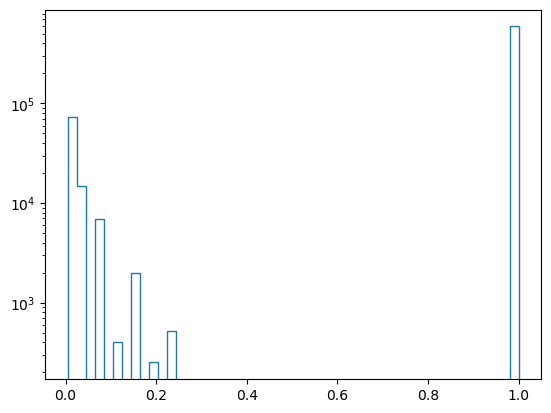

In [26]:
plt.hist(df['fake_factor'], bins=50, histtype='step')
print(len(df['fake_factor']))
plt.yscale('log')
plt.show()

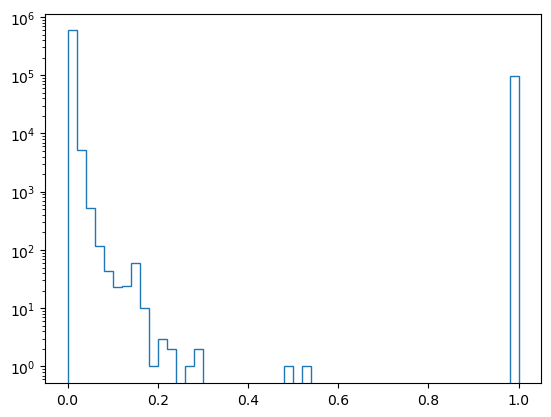

In [25]:
plt.hist(df['combined_weights'], bins=50, histtype='step')
plt.yscale('log')
plt.show()

In [50]:
# cathode_vars = ['bdt_score', 'ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'collinear_mass', 'met', 'higgs_pt', 'ditau_eta', 'leadsubjet_eta', 'subleadsubjet_eta', 'met_sig']
# cathode_train_vars = data_plot[cathode_vars]
# #apply mask of collenar mass between 00 and 300
# cathode_train_vars = cathode_train_vars[(cathode_train_vars['collinear_mass'] > 0) & (cathode_train_vars['collinear_mass'] < 300)]
# print(cathode_train_vars.shape)

# cathode_train, cathode_test = train_test_split(cathode_train_vars, test_size=0.3, random_state=42)

# print(cathode_train.shape)

# #save to npy files 
# np.save('/global/homes/a/agarabag/pscratch/sk_cathode/train.npy', cathode_train.to_numpy(), allow_pickle=True)
# np.save('/global/homes/a/agarabag/pscratch/sk_cathode/test.npy', cathode_test.to_numpy(), allow_pickle=True)

(114536, 11)
(80175, 11)


In [21]:
# Assuming df is your DataFrame
event_vars = df[['event_number', 'met', 'met_centrality', 'met_sig', 'ditau_pt', 'collinear_mass', 'visible_ditau_m', 'x1', 'x2', 'bdt_score']]
obj_vars_lead = df[['delta_eta_lead', 'delta_phi_lead', 'leadsubjet_pt', 'e_ratio_lead', 'delta_R_lead', 'leadsubjet_charge', 'leadsubjet_n_core_tracks']]
obj_vars_sublead = df[['delta_eta_sublead', 'delta_phi_sublead', 'subleadsubjet_pt', 'e_ratio_sublead', 'delta_R_sublead', 'subleadsubjet_charge', 'subleadsubjet_n_core_tracks']]
labels = df['label']
event_ids = df['event_number']

# Convert DataFrames to NumPy arrays
event_vars_array = event_vars.values
obj_vars_lead_array = obj_vars_lead.values
obj_vars_sublead_array = obj_vars_sublead.values
labels_array = labels.values
event_ids_array = event_ids.values

# Create zero-padded arrays for the additional subjets
zero_pad_shape = obj_vars_lead_array.shape
obj_vars_additional1 = np.zeros(zero_pad_shape)
obj_vars_additional2 = np.zeros(zero_pad_shape)

# Stack the object-level features along a new axis
obj_vars_combined = np.stack((obj_vars_lead_array, obj_vars_sublead_array, obj_vars_additional1, obj_vars_additional2), axis=1)

#get rid of nans or infs
event_mask = np.isfinite(event_vars_array).all(axis=1)
obj_mask = np.isfinite(obj_vars_combined).all(axis=(1,2))

# Combine the masks
valid_mask = event_mask & obj_mask

# Apply the mask to all relevant arrays
event_vars_array = event_vars_array[valid_mask]
obj_vars_combined = obj_vars_combined[valid_mask]
labels_array = labels_array[valid_mask]
event_ids_array = event_ids_array[valid_mask]


# Shuffle the data
np.random.seed(42)
permutation = np.random.permutation(event_vars_array.shape[0])
event_vars_array = event_vars_array[permutation]
obj_vars_combined = obj_vars_combined[permutation]
labels_array = labels_array[permutation]
event_ids_array = event_ids_array[permutation]

# Split the data based on event_id
eventID_mod = event_ids_array % 100

train_indices = np.where(eventID_mod < 60)[0]  # 60%
val_indices = np.where((eventID_mod >= 60) & (eventID_mod < 80))[0]  # 20%
test_indices = np.where(eventID_mod >= 80)[0]  # 20%

print("Train data count: ", len(train_indices))
print("Validation data count: ", len(val_indices))
print("Test data count: ", len(test_indices))

train_event, train_object, train_labels = event_vars_array[train_indices], obj_vars_combined[train_indices], labels_array[train_indices]
val_event, val_object, val_labels = event_vars_array[val_indices], obj_vars_combined[val_indices], labels_array[val_indices]
test_event, test_object, test_labels = event_vars_array[test_indices], obj_vars_combined[test_indices], labels_array[test_indices]

# Verify the shapes
print("Train event-level features shape:", train_event.shape)
print("Train object-level features shape:", train_object.shape)
print("Train labels shape:", train_labels.shape)

print("Validation event-level features shape:", val_event.shape)
print("Validation object-level features shape:", val_object.shape)
print("Validation labels shape:", val_labels.shape)

print("Test event-level features shape:", test_event.shape)
print("Test object-level features shape:", test_object.shape)
print("Test labels shape:", test_labels.shape)

Train data count:  1651671
Validation data count:  549474
Test data count:  549963
Train event-level features shape: (1651671, 10)
Train object-level features shape: (1651671, 4, 7)
Train labels shape: (1651671,)
Validation event-level features shape: (549474, 10)
Validation object-level features shape: (549474, 4, 7)
Validation labels shape: (549474,)
Test event-level features shape: (549963, 10)
Test object-level features shape: (549963, 4, 7)
Test labels shape: (549963,)


In [22]:
#how many 0 and 1 vlaues in val_labels
print("Validation label counts:")
print(np.unique(train_labels, return_counts=True))
#chekc if values of train_event are isfinite
print(np.isfinite(train_event).all())

Validation label counts:
(array([0, 1]), array([1626778,   24893]))
True
0
0


In [23]:
# Save to H5 files
output_dir = '/global/homes/a/agarabag/pscratch/ditdau_samples/samples_for_gnn_event_level/'
os.makedirs(output_dir, exist_ok=True)

with h5py.File(os.path.join(output_dir, 'train_tau.h5'), 'w') as train_file:
    train_file.create_dataset('data', data=train_object)
    train_file.create_dataset('jet', data=train_event)
    train_file.create_dataset('pid', data=train_labels)

with h5py.File(os.path.join(output_dir, 'test_tau.h5'), 'w') as test_file:
    test_file.create_dataset('data', data=test_object)
    test_file.create_dataset('jet', data=test_event)
    test_file.create_dataset('pid', data=test_labels)

with h5py.File(os.path.join(output_dir, 'val_tau.h5'), 'w') as val_file:
    val_file.create_dataset('data', data=val_object)
    val_file.create_dataset('jet', data=val_event)
    val_file.create_dataset('pid', data=val_labels)


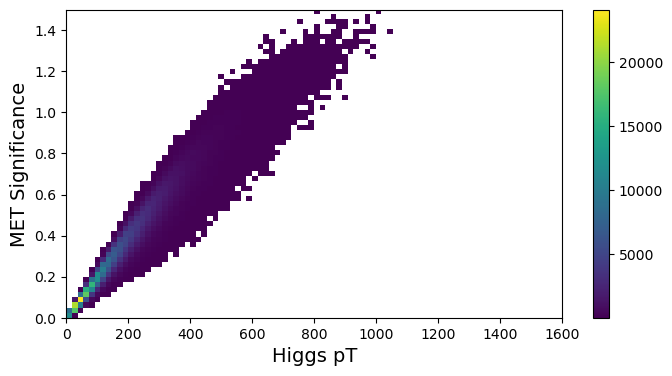

In [33]:
# plot x1 vs x2 in scatter plot. make it a heat map
plt.figure(figsize=(8, 4))

# plt.hist2d(ggh_plot['x1'], ggh_plot['x2'], bins=100, cmap='viridis', cmin=1)
# plt.hist2d(vbfh_plot['x1'], vbfh_plot['x2'], bins=100, cmap='viridis', cmin=1)
# plt.hist2d(wh_plot['x1'], wh_plot['x2'], bins=100, cmap='viridis', cmin=1)
# plt.hist2d(zh_plot['x1'], zh_plot['x2'], bins=100, cmap='viridis', cmin=1)
# plt.hist2d(tth_plot['x1'], tth_plot['x2'], bins=100, cmap='viridis', cmin=1)

# plt.hist2d(vv_plot['x1'], vv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(top_plot['x1'], top_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ztt_plot['x1'], ztt_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(ttv_plot['x1'], ttv_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(w_plot['x1'], w_plot['x2'], bins=50, cmap='viridis', cmin=3)
# plt.hist2d(zll_plot['x1'], zll_plot['x2'], bins=50, cmap='viridis', cmin=3)

# plt.hist2d(data_plot['delta_R'], data_plot['collinear_mass'], bins=100, cmap='viridis', cmin=3)
plt.hist2d(df['met'], df['met_sig'], bins=100, cmap='viridis', cmin=3)


plt.colorbar()
plt.xlabel('Higgs pT', fontsize=14)
plt.ylabel('MET Significance', fontsize=14)

#set y axis range
plt.ylim(0, 1.5)
plt.xlim(0, 1600)


plt.show()



In [98]:
ids = ggh_plot['event_number'] % 5 
#print count how mant ids equal 0, 1, 2, 3, 4
print("ggh", len(ggh_plot[ids == 0])+len(ggh_plot[ids == 1])+len(ggh_plot[ids == 2])+len(ggh_plot[ids == 3])+len(ggh_plot[ids == 4]))

ggh 480


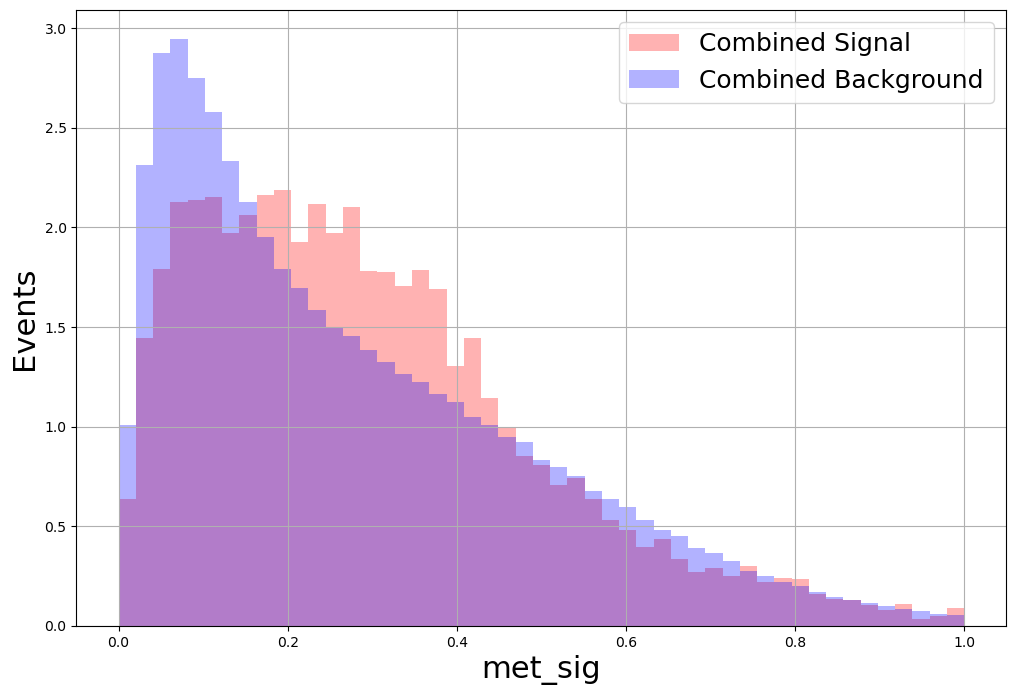

In [55]:
plt.figure(figsize=(12, 8))
plot_int = 'met_sig'
plt_bins = np.linspace(0, 1, 50)

# Combine signal and background processes
signal_processes = [ggh_plot, vbfh_plot, wh_plot, zh_plot, tth_plot]
background_processes = [vv_plot, data_plot, ztt_plot, zll_plot, w_plot, ttv_plot, top_plot]

# Calculate and plot combined signal histogram
combined_signal = np.concatenate([process[plot_int] for process in signal_processes])
plt.hist(combined_signal, bins=plt_bins, histtype='stepfilled', alpha=0.3, label='Combined Signal', color='red', density=True)

# Calculate and plot combined background histogram
combined_background = np.concatenate([
    vv_plot[plot_int],
    data_plot[plot_int],
    ztt_plot[plot_int],
    zll_plot[plot_int],
    w_plot[plot_int],
    ttv_plot[plot_int],
    top_plot[plot_int]
])
plt.hist(combined_background, bins=plt_bins, histtype='stepfilled', alpha=0.3, label='Combined Background', color='blue', density=True)

#make legend bigger
plt.legend(fontsize=18)
plt.grid(True)
plt.xlabel(plot_int, fontsize=22)
plt.ylabel('Events', fontsize=22)
# plt.yscale('log')
plt.show()

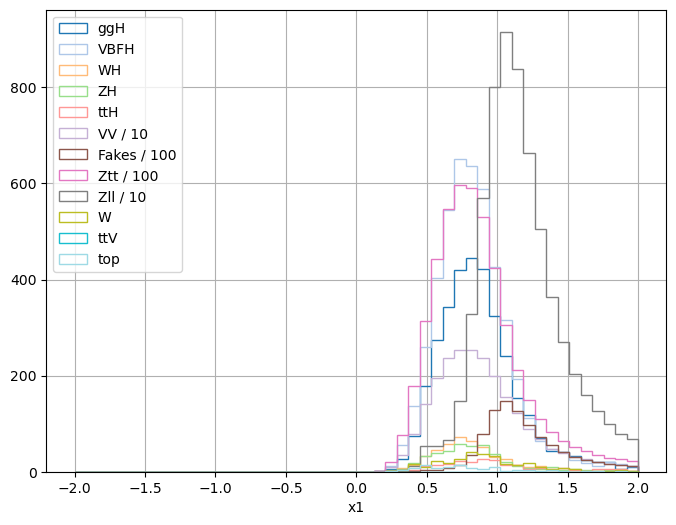

In [25]:
plt.figure(figsize=(8, 6))
plot_int = 'x1'
plt_bins = np.linspace(-2, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot signals 
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])

#plots backgrounds 
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

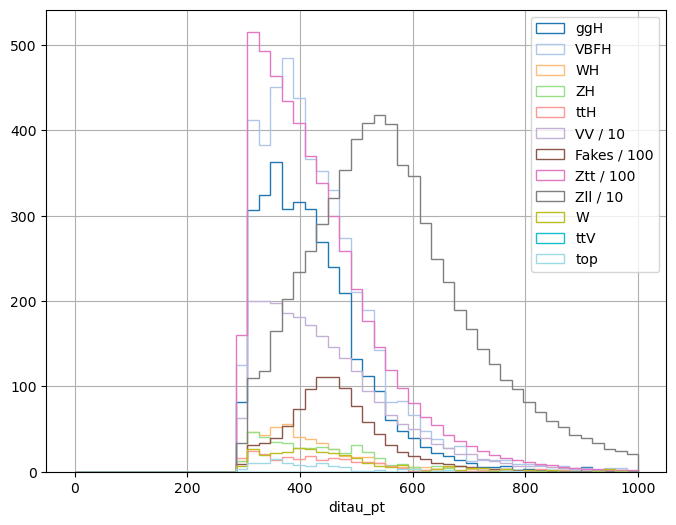

In [24]:
plt.figure(figsize=(8, 6))
plot_int = 'ditau_pt'
plt_bins = np.linspace(0, 1000, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
# plt.hist(np.log(ggh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
# plt.hist(np.log(vbfh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
# plt.hist(np.log(wh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
# plt.hist(np.log(zh_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
# plt.hist(np.log(tth_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
# plt.hist(np.log(vv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
# plt.hist(np.log(data_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
# plt.hist(np.log(ztt_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
# plt.hist(np.log(zll_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
# plt.hist(np.log(w_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
# plt.hist(np.log(ttv_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
# plt.hist(np.log(top_plot[plot_int]), bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])


plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

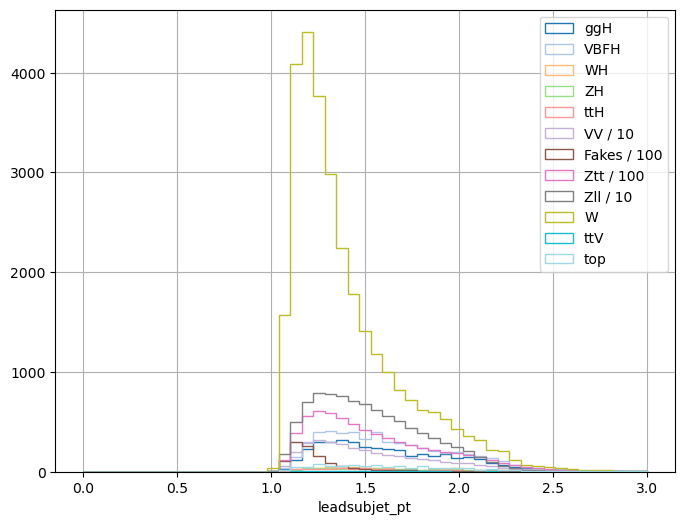

In [36]:
plt.figure(figsize=(8, 6))
plot_int = 'leadsubjet_pt'
plt_bins = np.linspace(0, 3, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot['ditau_pt']/ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot['ditau_pt']/vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot['ditau_pt']/wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot['ditau_pt']/zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot['ditau_pt']/tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot['ditau_pt']/vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot['ditau_pt']/data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot['ditau_pt']/ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot['ditau_pt']/zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot['ditau_pt']/w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot['ditau_pt']/ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot['ditau_pt']/top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

In [66]:
np.log(1 - ggh_plot['ditau_pt']/ggh_plot[plot_int])

/global/homes/a/agarabag/.conda/envs/ditau/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
989   NaN
990   NaN
991   NaN
992   NaN
993   NaN
Length: 994, dtype: float64

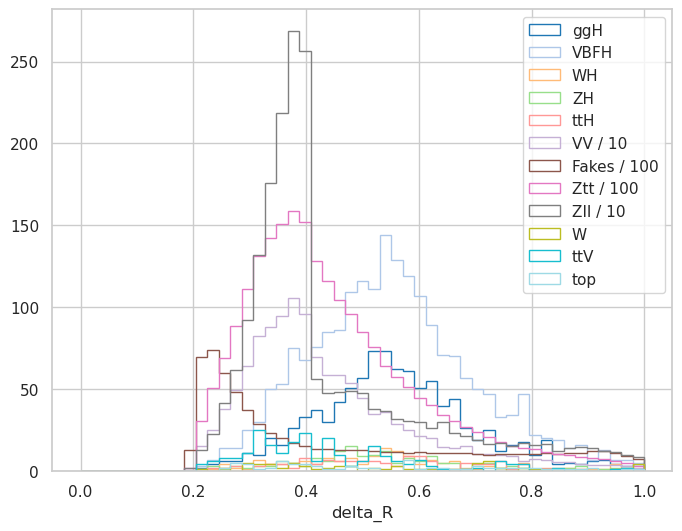

In [21]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_R'
plt_bins = np.linspace(0, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100', weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.xlabel(plot_int)
plt.show()

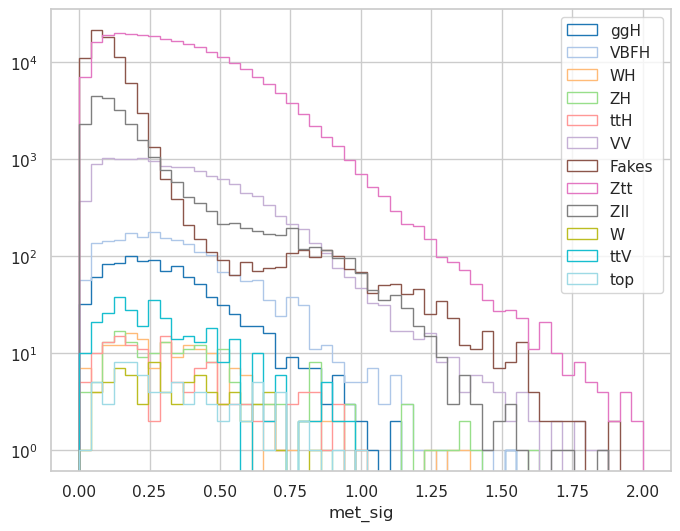

In [28]:
plt.figure(figsize=(8, 6))
plot_int = 'met_sig'
plt_bins = np.linspace(0, 2, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV ', color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes ', color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt ', color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll ', color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

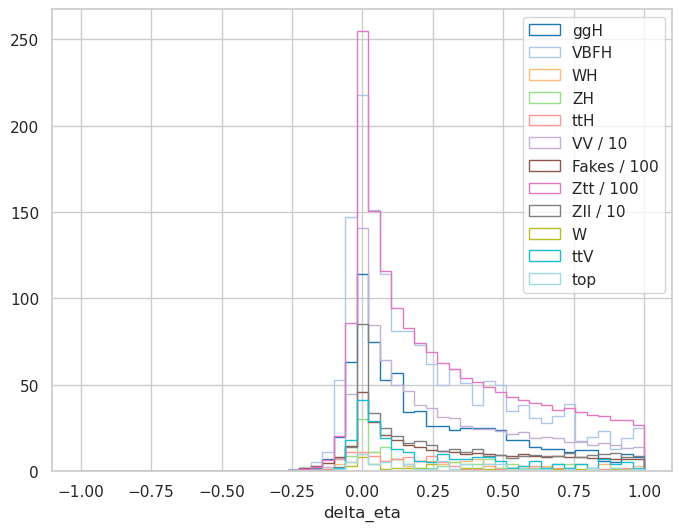

In [49]:
plt.figure(figsize=(8, 6))
plot_int = 'delta_eta'
plt_bins = np.linspace(-1, 1, 50)

# Define a list of 12 unique colors
colors = plt.cm.tab20(np.linspace(0, 1, 12))

# Plot each histogram with a unique color
plt.hist(ggh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ggH', color=colors[0])
plt.hist(vbfh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VBFH', color=colors[1])
plt.hist(wh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='WH', color=colors[2])
plt.hist(zh_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ZH', color=colors[3])
plt.hist(tth_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttH', color=colors[4])
plt.hist(vv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='VV / 10', weights=np.ones_like(vv_plot[plot_int])/10, color=colors[5])
plt.hist(data_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Fakes / 100',  weights=np.ones_like(data_plot[plot_int])/100, color=colors[6])
plt.hist(ztt_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Ztt / 100', weights=np.ones_like(ztt_plot[plot_int])/100, color=colors[7])
plt.hist(zll_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='Zll / 10', weights=np.ones_like(zll_plot[plot_int])/10, color=colors[8])
plt.hist(w_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='W', color=colors[9])
plt.hist(ttv_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='ttV', color=colors[10])
plt.hist(top_plot[plot_int], bins=plt_bins, histtype='step', linewidth=1, label='top', color=colors[11])

plt.legend()
plt.grid(True)
# plt.yscale('log')
plt.xlabel(plot_int)
plt.show()

In [47]:
# # plot_var = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'ditau_m', 'leadsubjet_eta', 'subleadsubjet_eta',
# #     'leadsubjet_phi', 'subleadsubjet_phi'
# # ]
# plot_var = [
# 'leadsubjet_pT', 'subleadsubjet_pT', 'visible_ditau_m', 'met', 'k_t', 'kappa', 'delta_R', 'delta_phi', 'delta_eta'
# ]

# plt.figure(figsize=(40, 36))
# def hist(variable, plot_num):
#     print("Start Plot:", variable)
#     plt.subplot(3, 3, plot_num+1)
#     bin = 50
#     plt.hist(ggh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'ggH ')
#     plt.hist(vbfh_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VBFH ')
#     plt.hist(vv_plot[variable], bins=bin, histtype='step', linewidth=1, label=f'VV ')
#     # plt.hist(ztt_plot[i], bins=bin, histtype='step', linewidth=1, label=f'Ztt ', weights=np.ones_like(ztt_plot[i])/10)
#     plt.xlabel(variable)
#     #plt.ylabel("Number of Events (scaled)")
#     #plt.title(xlabel)
# #     plt.yscale('log')
#     plt.legend()
#     plt.grid(True)

# for i, label in enumerate(plot_var, 0):
#     hist(label, i)

In [ ]:
ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

# ggh_plt = plt_to_root_hist_w(ggh_plot[2], 10, 0, 150, None, False)
# ggh_plt.SetLineColor(ROOT.kRed)
# ggh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot[2], 10, 0, 150, None, False)
# vbfh_plt.SetLineColor(ROOT.kBlue)
# vbfh_plt.SetMarkerColor(ROOT.kBlue)
# vv_plt = plt_to_root_hist_w(vv_plot[2], 10, 0, 150, None, False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# ztt_plt = plt_to_root_hist_w(ztt_plot[2], 10, 0, 150, None, False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['visible_ditau_m'], vbfh_plot['visible_ditau_m'], wh_plot['visible_ditau_m'], zh_plot['visible_ditau_m'], tth_plot['visible_ditau_m']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 150, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['visible_ditau_m'], ztt_plot['visible_ditau_m'], w_plot['visible_ditau_m'], top_plot['visible_ditau_m'], zll_plot['visible_ditau_m'], ttv_plot['visible_ditau_m'], data_plot['visible_ditau_m']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['visible_ditau_m'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 150, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

# ggh_plt = plt_to_root_hist_w(ggh_plot['visible_ditau_m'], 20, 0, 150, ggh_plot['combined_weights']*lumi_scale_factor, False)
# ggh_plt.SetLineColor(ROOT.kBlue)
# ggh_plt.SetMarkerColor(ROOT.kBlue)
# ggh_plt.SetMarkerStyle(20)
# vbfh_plt = plt_to_root_hist_w(vbfh_plot['visible_ditau_m'], 20, 0, 150, vbfh_plot['combined_weights']*lumi_scale_factor, False)
# vbfh_plt.SetLineColor(ROOT.kRed)
# vbfh_plt.SetMarkerColor(ROOT.kRed)
# vbfh_plt.SetMarkerStyle(20)
# vh_plt = plt_to_root_hist_w(vh_plot['visible_ditau_m'], 20, 0, 150, vh_plot['combined_weights']*lumi_scale_factor, False)
# vh_plt.SetLineColor(ROOT.kYellow)
# vh_plt.SetMarkerColor(ROOT.kYellow)
# vh_plt.SetMarkerStyle(20)
# wh_plt = plt_to_root_hist_w(wh_plot['visible_ditau_m'], 20, 0, 150, wh_plot['combined_weights']*lumi_scale_factor, False)
# wh_plt.SetLineColor(ROOT.kGreen)
# wh_plt.SetMarkerColor(ROOT.kGreen)
# wh_plt.SetMarkerStyle(20)
# zh_plt = plt_to_root_hist_w(zh_plot['visible_ditau_m'], 20, 0, 150, zh_plot['combined_weights']*lumi_scale_factor, False)
# zh_plt.SetLineColor(ROOT.kOrange)
# zh_plt.SetMarkerColor(ROOT.kOrange)
# zh_plt.SetMarkerStyle(20)
# tth_plt = plt_to_root_hist_w(tth_plot['visible_ditau_m'], 20, 0, 150, tth_plot['combined_weights']*lumi_scale_factor, False)
# tth_plt.SetLineColor(ROOT.kMagenta)
# tth_plt.SetMarkerColor(ROOT.kMagenta)
# tth_plt.SetMarkerStyle(20)

# vv_plt = plt_to_root_hist_w(vv_plot['visible_ditau_m'], 20, 0, 150, vv_plot['combined_weights'], False)
# vv_plt.SetLineColor(ROOT.kGreen)
# vv_plt.SetMarkerColor(ROOT.kGreen)
# vv_plt.SetMarkerStyle(20)
# ztt_plt = plt_to_root_hist_w(ztt_plot['visible_ditau_m'], 20, 0, 150, ztt_plot['combined_weights'], False)
# ztt_plt.SetLineColor(ROOT.kOrange)
# ztt_plt.SetMarkerColor(ROOT.kOrange)
# ztt_plt.SetMarkerStyle(20)
# w_plt = plt_to_root_hist_w(W_plot['visible_ditau_m'], 20, 0, 150, W_plot['combined_weights'], False)
# w_plt.SetLineColor(ROOT.kBlack)
# w_plt.SetMarkerColor(ROOT.kBlack)
# w_plt.SetMarkerStyle(20)
# top_plt = plt_to_root_hist_w(Top_plot['visible_ditau_m'], 20, 0, 150, Top_plot['combined_weights'], False)
# top_plt.SetLineColor(ROOT.kGray)
# top_plt.SetMarkerColor(ROOT.kGray)
# top_plt.SetMarkerStyle(20)
# zll_inc_plt = plt_to_root_hist_w(Zll_inc_plot['visible_ditau_m'], 20, 0, 150, Zll_inc_plot['combined_weights'], False)
# zll_inc_plt.SetLineColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerColor(ROOT.kCyan)
# zll_inc_plt.SetMarkerStyle(20)

# ggh_plt.Scale(1. / ggh_plt.Integral())
# vbfh_plt.Scale(1. / vbfh_plt.Integral())
# vv_plt.Scale(1. / vv_plt.Integral())
# ztt_plt.Scale(1. / ztt_plt.Integral())

# ztt_plt.Draw("hist e ")
# zll_inc_plt.Draw("hist e same")
# vv_plt.Draw("hist e same")
# top_plt.Draw("hist e same")
# w_plt.Draw("hist e same")
# vbfh_plt.Draw("hist e same")
# ggh_plt.Draw("hist e same")
# zh_plt.Draw("hist e same")
# wh_plt.Draw("hist e same")
# tth_plt.Draw("hist e same")
# vh_plt.Draw("hist e same")

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_background.Draw("hist e")
all_signal.Draw("hist e same")

all_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
# legend.AddEntry(vv_plt, "VV")
# legend.AddEntry(ztt_plt, "Ztt")
# legend.AddEntry(w_plt, "W")
# legend.AddEntry(top_plt, "Top")
# legend.AddEntry(zll_inc_plt, "Zll_inc")

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [ ]:
%jsroot on

ROOT.gROOT.SetStyle("ATLAS")
canvas = ROOT.TCanvas("canvas", "eff_plots", 500, 500)
canvas.Clear()
canvas.cd()

#combine signal to one plot
all_signal = np.concatenate((ggh_plot['collinear_mass'], vbfh_plot['collinear_mass'], wh_plot['collinear_mass'], zh_plot['collinear_mass'], tth_plot['collinear_mass']))
all_signal_weights = np.concatenate((ggh_plot['combined_weights'], vbfh_plot['combined_weights'], wh_plot['combined_weights'], zh_plot['combined_weights'], tth_plot['combined_weights']))
all_signal = plt_to_root_hist_w(all_signal, 10, 0, 200, all_signal_weights, False)
all_signal.SetLineColor(ROOT.kRed)
all_signal.SetMarkerColor(ROOT.kRed)
all_signal.SetMarkerStyle(20)

#combine background to one plot
all_background = np.concatenate((vv_plot['collinear_mass'], ztt_plot['collinear_mass'], w_plot['collinear_mass'], top_plot['collinear_mass'], zll_plot['collinear_mass'], ttv_plot['collinear_mass'], data_plot['collinear_mass']))
all_background_weights = np.concatenate((vv_plot['combined_weights'], ztt_plot['combined_weights'], w_plot['combined_weights'], top_plot['combined_weights'], zll_plot['combined_weights'], ttv_plot['combined_weights'], np.ones_like(data_plot['collinear_mass'])))
all_background = plt_to_root_hist_w(all_background, 10, 0, 200, all_background_weights, False)
all_background.SetLineColor(ROOT.kGreen)
all_background.SetMarkerColor(ROOT.kGreen)
all_background.SetMarkerStyle(20)

all_background.Scale(1. / all_background.Integral())
all_signal.Scale(1. / all_signal.Integral())

all_signal.Draw("hist e same")
all_background.Draw("hist e same")

all_background.GetXaxis().SetTitle('Collinear Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)

legend.AddEntry(all_signal, "Signal")
legend.AddEntry(all_background, "Background")

legend.Draw()
canvas.Draw()


In [43]:
s = (0.1 + 0.001) * np.log(1 + 0.1 / 0.001) - 0.1
s = np.sqrt(2 * s)
s

0.855718612864027

In [26]:
significance_bin_by_bin(all_signal, all_background, s_much_less_than_b=False)

NameError: name 'significance_bin_by_bin' is not defined

In [ ]:
# make root fplot of all signal stracked together and all background stacked together
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#stacked signal
# stacked_signal = ROOT.THStack("stacked_signal", "stacked_signal")
# stacked_signal.Add(ggh_plt)
# stacked_signal.Add(vbfh_plt)
# stacked_signal.Add(vh_plt)
# stacked_signal.Add(wh_plt)
# stacked_signal.Add(zh_plt)
# stacked_signal.Add(tth_plt)

#stacked background
stacked_background = ROOT.THStack("stacked_background", "stacked_background")
stacked_background.Add(vv_plt)
stacked_background.Add(ztt_plt)
stacked_background.Add(w_plt)
stacked_background.Add(top_plt)
stacked_background.Add(zll_inc_plt)

stacked_background.Draw("hist e")
all_signal.Draw("hist e same")

stacked_background.GetXaxis().SetTitle('Visible DiTau Mass')

legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.9)
legend.SetBorderSize(0)
legend.SetFillColor(0)
# legend.AddEntry(ggh_plt, "ggH")
# legend.AddEntry(vbfh_plt, "VBFH")
# legend.AddEntry(vh_plt, "VH")
# legend.AddEntry(wh_plt, "WH")
# legend.AddEntry(zh_plt, "ZH")
# legend.AddEntry(tth_plt, "ttH")
legend.AddEntry(all_signal, "Signal")
legend.AddEntry(vv_plt, "VV")
legend.AddEntry(ztt_plt, "Ztt")
legend.AddEntry(w_plt, "W")
legend.AddEntry(top_plt, "Top")
legend.AddEntry(zll_inc_plt, "Zll")
#make legend text size bigger
legend.SetTextSize(0.02)
#sapce out the markers in the legend
legend.SetMargin(0.5)
#sepreate markers in the legend
legend.SetEntrySeparation(0.1)


legend.Draw()

canvas.Draw()


In [35]:
#check how many rows there are with label 1 and 0
df['label'].value_counts()

label
0    681062
1      9106
Name: count, dtype: int64

In [36]:
df.loc[df['combined_weights'] < 0, 'combined_weights']

Series([], Name: combined_weights, dtype: float64)

In [54]:
def split_data(df):
    # Split data based on event number
    ids = df['event_number'] % 3
    #append ids to the dataframe
    df['ids'] = ids
    print("All sample Split:", len(df[ids == 0]), len(df[ids == 1]), len(df[ids == 2]), len(df[ids == 3]), len(df[ids == 4]))
    #print how many signal and background events are in each set
    print("Signal Split:", len(df[(df['label'] == 1) & (df['ids'] == 0)]), len(df[(df['label'] == 1) & (df['ids'] == 1)]), len(df[(df['label'] == 1) & (df['ids'] == 2)]), len(df[(df['label'] == 1) & (df['ids'] == 3)]), len(df[(df['label'] == 1) & (df['ids'] == 4)]))
    print("Background Split:", len(df[(df['label'] == 0) & (df['ids'] == 0)]), len(df[(df['label'] == 0) & (df['ids'] == 1)]), len(df[(df['label'] == 0) & (df['ids'] == 2)]), len(df[(df['label'] == 0) & (df['ids'] == 3)]), len(df[(df['label'] == 0) & (df['ids'] == 4)]))
    # return [df[ids == 0], df[ids == 1], df[ids == 2], df[ids == 3], df[ids == 4]]
    return [df[ids == 0], df[ids == 1], df[ids == 2]]

In [55]:
#split the data into 5 sets
df_split = split_data(df)

#print number of features in df
print(df_split[0].columns)

All sample Split: 260186 259737 259401 0 0
Signal Split: 3207 3183 3286 0 0
Background Split: 256979 256554 256115 0 0
Index(['ditau_pt', 'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m',
       'collinear_mass', 'delta_R', 'delta_phi', 'delta_eta', 'label', 'met',
       'met_sig', 'met_centrality', 'event_number', 'fake_factor',
       'combined_weights', 'k_t', 'x1', 'x2', 'sample_type', 'bdt_score',
       'leadsubjet_charge', 'subleadsubjet_charge', 'leadsubjet_n_core_tracks',
       'subleadsubjet_n_core_tracks', 'delta_R_lead', 'delta_eta_lead',
       'delta_phi_lead', 'delta_R_sublead', 'delta_eta_sublead',
       'delta_phi_sublead', 'e_ratio_lead', 'e_ratio_sublead', 'ids'],
      dtype='object')


len X_train: 519138
len X_test: 260186
signal scaling factor:  79.2501159375483
len X_train: 519587
len X_test: 259737
signal scaling factor:  79.02263976590174
len X_train: 519923
len X_test: 259401
signal scaling factor:  80.36510172143974


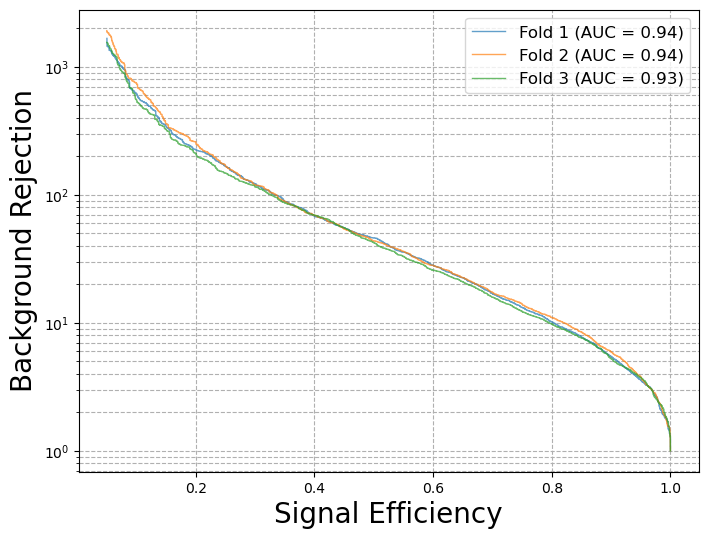

In [56]:
# models = []
signal_scores = []
background_scores = []
signal_weights = []
bkg_weghts = []

all_shap_values = []
all_feature_names = []

# bdt_training_var = ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18']
bdt_training_var = ['f3', 'f14', 'f4', 'f5', 'f6', 'f7', 'f1']

feature_name_mapping = {
    'leadsubjet_pt': 'f0',
    'subleadsubjet_pt': 'f1',
    'visible_ditau_m': 'f2',
    'collinear_mass': 'f3',
    'delta_R': 'f4',
    'met': 'f5',
    'met_sig': 'f6',
    'met_centrality': 'f7',
    'delta_eta_lead': 'f8',
    'delta_phi_lead': 'f9',
    'e_ratio_lead': 'f10',
    'e_ratio_sublead': 'f11',
    'x1': 'f12',
    'x2': 'f13',
    'bdt_score': 'f14',
    'delta_R_lead': 'f15',
    'delta_R_sublead': 'f16',
    'delta_eta_sublead': 'f17',
    'delta_phi_sublead': 'f18',
}


#map df_split cloumn names 
for i in range(len(df_split)):
    df_split[i] = df_split[i].rename(columns=feature_name_mapping)

# print(df_split[0])
plt.figure(figsize=(8, 6))

for i in range(len(df_split)):

    X_test = df_split[i][bdt_training_var]
    y_test = df_split[i]['label']
    evnt_w_test = df_split[i]['combined_weights']
    ff_test = df_split[i]['fake_factor']

    X_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])[bdt_training_var]
    y_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['label']
    evnt_w_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['combined_weights']
    ff_train = pd.concat([df_split[j] for j in range(len(df_split)) if j != i])['fake_factor']

    training_weight = ff_train*evnt_w_train
    val_weights = ff_test*evnt_w_test
    # training_weight = training_weight / np.mean(training_weight)
    # val_weights = val_weights / np.mean(val_weights)

    print("len X_train:", len(X_train))
    print("len X_test:", len(X_test))

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
    print("signal scaling factor: ", scale_pos_weight)
    
    params = {
    'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 200,
    'eval_metric': 'logloss',
    'random_state': 2,
    'scale_pos_weight': scale_pos_weight,
    'base_score': 0.5,
    'objective':'binary:logistic', 
    'gamma': 0.001,
    'verbosity': 1
    }
    model = XGBClassifier(**params)
    # Train the model
    model.fit(X_train, y_train, sample_weight=training_weight)
    # models.append(model)
    booster = model.get_booster()
    booster.dump_model('xgboost_k_fold_model_{}.txt'.format(i))

    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    all_shap_values.append(shap_values)
    # Reverse the feature_name_mapping
    reversed_feature_name_mapping = {v: k for k, v in feature_name_mapping.items()}
    X_test_renamed = X_test.rename(columns=reversed_feature_name_mapping)
    all_feature_names.append(X_test_renamed.columns)
    # all_feature_names.append(X_test.columns)

    # Predict probabilities for the test set
    y_pred_proba = model.predict_proba(X_test)
    # Extract scores for signal and background
    signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
    background_scores.extend(y_pred_proba[:, 1][y_test == 0])

    #add scores to df panda frame
    df_split[i]['mva_scores'] = y_pred_proba[:, 1]

    signal_weights.extend(ff_test[y_test == 1]*-1/ff_scale)
    bkg_weghts.extend(ff_test[y_test == 0]*-1/ff_scale)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1], sample_weight=val_weights)
    fpr = fpr[tpr > 0.05]
    tpr = tpr[tpr > 0.05]
    roc_auc = auc(fpr, tpr)
    plt.plot(tpr, 1/fpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')

# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
plt.xlabel('Signal Efficiency', fontsize=20)
plt.ylabel('Background Rejection', fontsize=20)
plt.legend(fontsize=12)
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()



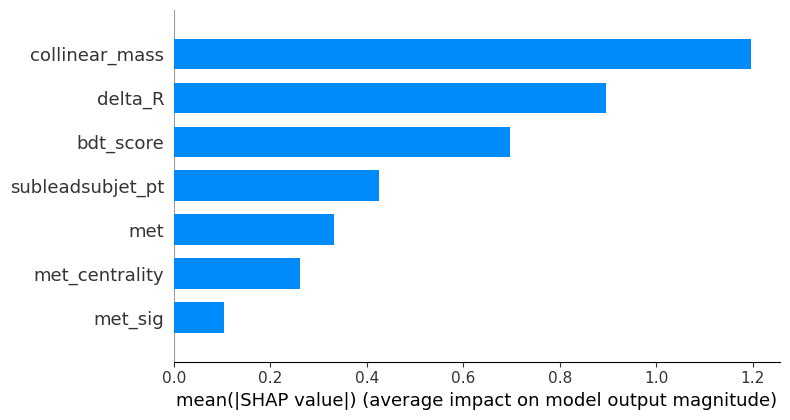

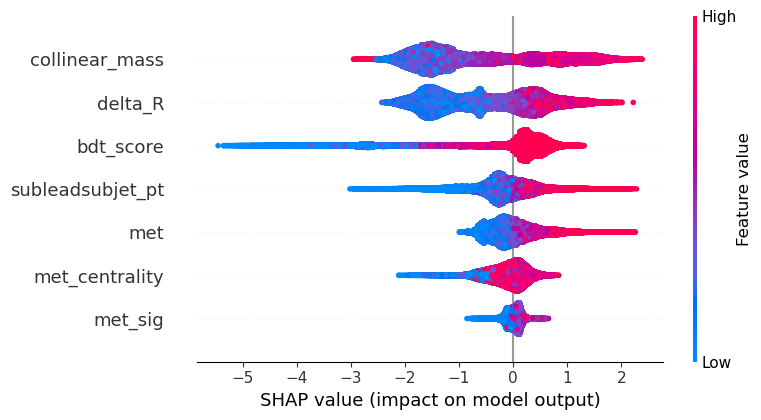

Feature Importance Ranking:
            feature  importance
0    collinear_mass    1.195570
2           delta_R    0.889375
1         bdt_score    0.689333
6  subleadsubjet_pt    0.390567
3               met    0.344830
5    met_centrality    0.233594
4           met_sig    0.137589


In [57]:
# Aggregate SHAP values across all folds
mean_shap_values = np.mean([np.abs(shap_values).mean(0) for shap_values in all_shap_values], axis=0)
feature_names = all_feature_names[0]  # Assuming feature names are consistent across folds

# Sort features by importance
feature_importance = pd.DataFrame({'feature': feature_names, 'importance': mean_shap_values})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plot feature importance
shap.summary_plot(all_shap_values[2], X_test, plot_type="bar", feature_names=feature_names)
shap.summary_plot(all_shap_values[2], X_test, feature_names=feature_names)

# Print feature importance
print("Feature Importance Ranking:")
print(feature_importance)

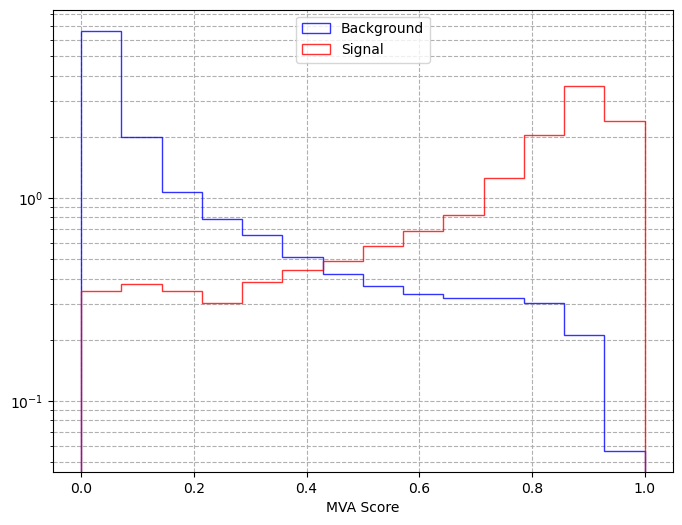

In [58]:
plt.figure(figsize=(8, 6))
plt.hist(background_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='blue', label='Background', histtype='step', density=True)
plt.hist(signal_scores, bins=np.linspace(0, 1, 15), alpha=0.8, color='red', label='Signal', histtype='step', density=True)
plt.xlabel('MVA Score')
plt.yscale('log')
plt.legend(loc='upper center')
plt.grid(True, which="both", ls="--")
plt.show()

In [64]:
#select df_split[0] for mv score values bigger than 0.8 and label = 0
df_test = df_split[0][(df_split[0]['mva_scores'] > 0.8) & (df_split[0]['label'] == 0) & (df_split[0]['sample_type'] == 'w')]
print(len(df_test))
#print truth variables
#    'boson_0_classifierParticleOrigin', 'boson_0_mother_pdgId', 'boson_0_mother_status', 'boson_0_pdgId', 'boson_0_truth_pdgId', 'boson_0_truth_q', 'boson_0_truth_status', 'boson_0_q', 'ditau_obj_IsTruthMatched', 'ditau_obj_IsTruthHadronic'

print(df_test['boson_0_classifierParticleOrigin'])
print(df_test['boson_0_mother_pdgId'])
print(df_test['boson_0_mother_status'])
print(df_test['boson_0_pdgId'])
print(df_test['boson_0_truth_pdgId'])
print(df_test['boson_0_truth_q'])
print(df_test['boson_0_truth_status'])
print(df_test['boson_0_q'])
print(df_test['ditau_obj_IsTruthMatched'])  
print(df_test['ditau_obj_IsTruthHadronic'])

#check if ditau_obj_IsTruthHadronic ever equals 1
print(df_test['ditau_obj_IsTruthHadronic'].value_counts())


19
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_classifierParticleOrigin, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_mother_pdgId, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_mother_status, dtype: float64
41     0.0
42     0.0
75     0.0
80     0.0
91     0.0
115    0.0
124    0.0
211    0.0
232    0.0
239    0.0
250    0.0
255    0.0
256    0.0
287    0.0
295    0.0
303    0.0
310    0.0
318    0.0
352    0.0
Name: boson_0_pdgId

In [85]:
sig_hist = plt_to_root_hist_w(signal_scores, 15, 0., 1., None, False)
bkg_hist = plt_to_root_hist_w(background_scores, 15, 0., 1., None, False)
sig_hist.Scale(1/sig_hist.Integral())
bkg_hist.Scale(1/bkg_hist.Integral())
significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False)

1.7454814702336394

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [62]:
# # Initialize k-fold cross-validation
# # kf = KFold(n_splits=5, shuffle=True, random_state=42)
# kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
# # Initialize lists to store scores
# signal_scores = []
# background_scores = []
# proba_and_values = []
# models = []

# training_var = [
#     'leadsubjet_pT', 'subleadsubjet_pT',
#     'visible_ditau_m', 'delta_R', 'met', 'label'
# ]
# X = df[training_var[:-1]]  # Features
# print(X.columns)
# y = df['label']  # Target variable

# scale_pos_weight = len(y[y == 0]) / len(y[y == 1])
# print(scale_pos_weight)
# plt.figure(figsize=(8, 6))

# # Iterate through each fold
# # for train_index, test_index in kf.split(X):
# for i, (train_index, test_index) in enumerate(kf.split(X, y)):
#     # Split train and test sets
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]
#     #change column names to f1, f2, f3, f4, f5
#     X_train.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
#     X_test.columns = ['f0', 'f1', 'f2', 'f3', 'f4']
    
#     params = {
#     'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
#     model = XGBClassifier(**params)
#     # Train the model
#     model.fit(X_train, y_train)
#     models.append(model)

#     # Predict probabilities for the test set
#     y_pred_proba = model.predict_proba(X_test)
#     # Extract scores for signal and background
#     signal_scores.extend(y_pred_proba[:, 1][y_test == 1])
#     background_scores.extend(y_pred_proba[:, 1][y_test == 0])

#     # save the proba correspoending to the X_test values
#     proba_and_values.append((y_pred_proba, X_test))

#     fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr, tpr, lw=1, alpha=0.7, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# plt.plot([0, 1], [0, 1], linestyle='--', color='black', lw=2, label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve - Each Fold')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()


In [109]:
# from sklearn.model_selection import cross_val_predict

# params = {
#     'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     # 'base_score': 1.e-9,
#     # 'max_delta_step': 3,
#     'objective':'binary:logistic', 
#     # 'num_class': 1,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# model_n = XGBClassifier(**params)

# # Perform cross-validation predictions
# y_pred_proba_cv = cross_val_predict(model_n, X, y, cv=5, method='predict_proba')

# # Get the predicted probabilities for the positive class
# positive_class_proba = y_pred_proba_cv[:, 1]


In [110]:
# plt.figure(figsize=(8, 6))
# plt.hist(positive_class_proba[y == 1], bins=10, alpha=0.8, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(positive_class_proba[y == 0], bins=10, alpha=0.8, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

# sig_hist = plt_to_root_hist_w(positive_class_proba[y == 1], 10, 0., 1., None, False)
# bkg_hist = plt_to_root_hist_w(positive_class_proba[y == 0], 10, 0., 1., None, False)
# sig_hist.Scale(1/sig_hist.Integral())
# bkg_hist.Scale(1/bkg_hist.Integral())
# significance_bin_by_bin(sig_hist, bkg_hist, s_much_less_than_b=False) ###0.99 with False

In [72]:
import xgboost as xgb
def get_basescore(model: xgb.XGBModel) -> float:
    import json

    """Get base score from an XGBoost sklearn estimator."""
    base_score = float(json.loads(model.get_booster().save_config())["learner"]["learner_model_param"]["base_score"])
    return base_score

print(get_basescore(model)) # usually 0.5

0.5


In [115]:
# # Load the XGBoost model
# trained_model = XGBClassifier()
# trained_model.load_model('xgboost_k_fold_model_v05.bin')

# # calucalte score values with X_train
# y_pred_proba_now = trained_model.predict_proba(X)

# k_fold_y_pred_proba_signal = y_pred_proba_now[:, 1][y == 1]
# k_fold_y_pred_proba_background = y_pred_proba_now[:, 1][y == 0]

In [ ]:
%jsroot on
ROOT.gROOT.SetStyle("ATLAS")

# plot sig_hist and bkg_hist
canvas = ROOT.TCanvas("canvas", "eff_plots", 600, 600)
canvas.Clear()
canvas.cd()

#plot signal
sig_hist.SetLineColor(ROOT.kRed)
sig_hist.SetMarkerColor(ROOT.kRed)
sig_hist.SetMarkerStyle(20)
#plot background
bkg_hist.SetLineColor(ROOT.kBlue)
bkg_hist.SetMarkerColor(ROOT.kBlue)
bkg_hist.SetMarkerStyle(20)

#set y axis range 
# bkg_hist.GetYaxis().SetRangeUser(0, 0.42)

sig_hist.Draw("hist e")
bkg_hist.Draw("hist e same")

sig_hist.GetXaxis().SetTitle('Score')

legend = ROOT.TLegend(0.3, 0.7, 0.6, 0.6)
legend.SetBorderSize(0)
legend.SetFillColor(0)
legend.AddEntry(sig_hist, "Signal")
legend.AddEntry(bkg_hist, "Background")


legend.Draw()

canvas.Draw()



In [128]:
# #split the data into training and testing
# # training_var_s = [
# #     'leadsubjet_pT', 'subleadsubjet_pT',
# #     'visible_ditau_m', 'delta_R'
# # ]
# training_var_s = ['leadsubjet_pT',
#     'subleadsubjet_pT',
#     'visible_ditau_m',
#     'collinear_mass',
#     'delta_R',
#     'met',
#     'met_sig',
#     'delta_phi',
#     'delta_eta'
# ]
# X = df[training_var_s]
# y = df['label']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)

# # print(X_train)
# #save weights in a separate variable
# # weights_train = np.abs(X_train['combined_weights']*lumi_scale_factor)
# # weights_test = np.abs(X_test['combined_weights']*lumi_scale_factor)

# # weights should not be included in the training data
# # X_train.drop(columns='combined_weights', inplace=True)
# # X_test.drop(columns='combined_weights', inplace=True)

# #Change column names to integers if needed (for ML models that expect numerical feature names)
# # feature_mapping = {feature: i for i, feature in enumerate(X_train.columns)}
# # X_train.rename(columns=feature_mapping, inplace=True)
# # X_test.rename(columns=feature_mapping, inplace=True)

# # istead of integers call the vaibels f1, f2, f3, f4
# # X_train.columns = ['f0', 'f1', 'f2', 'f3']
# # X_test.columns = ['f0', 'f1', 'f2', 'f3']
# print(X_train.shape)
# print(X_test.shape)

# #print size of training and testing data
# # print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, weights_train.shape, weights_test.shape)
# print(X_train)


In [129]:
# # create the BDT
# params = {
#     'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100,
#     'eval_metric': 'logloss',
#     'random_state': 2,
#     'scale_pos_weight': scale_pos_weight,
#     'base_score': 0.5,
#     'gamma': 0.001,
#     'verbosity': 1
#     }
# bdt = XGBClassifier(**params)

# # Train the classifier
# # bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)], sample_weight=weights_train)
# bdt.fit(X_train, y_train, eval_set=[(X_test, y_test)])


In [130]:
# # plot the ROC curve
# # print(bdt.predict_proba(X_test).shape)
# # print(bdt.predict_proba(X_test))
# print(X_test)
# y_pred = bdt.predict_proba(X_test)[:, 1]
# print(y_pred)
# # fpr, tpr, thresholds = roc_curve(y_test, y_pred, sample_weight=weights_test)
# # roc_auc = roc_auc_score(y_test, y_pred, sample_weight=weights_test)
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, label=f'(AUC={roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='k', label='Random')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.figure(figsize=(8, 6))
# plt.plot(tpr, 1/fpr, lw=1)
# plt.xlabel('Signal efficiency (TPR)')
# plt.ylabel('Inverse background efficiency (1/FPR)')
# plt.yscale('log')
# plt.grid(True, which="both", ls="--")
# plt.show()

# print(len(y_pred[y_test == 1]), len(y_pred[y_test == 0]))

# signal_scores = y_pred[y_test == 1]
# background_scores = y_pred[y_test == 0]
# plt.figure(figsize=(8, 6))
# plt.hist(signal_scores, bins=10, alpha=0.5, color='blue', label='Signal', histtype='step', density=True)
# plt.hist(background_scores, bins=10, alpha=0.5, color='red', label='Background', histtype='step', density=True)
# plt.xlabel('Score')
# # plt.yscale('log')
# plt.legend(loc='upper center')
# plt.grid(True)
# plt.show()

In [ ]:
# ##### with weights 


# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader, TensorDataset
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Hyperparameters
# learning_rate = 0.00008
# batch_size = 128
# dropout = 0
# neuron1 = 64
# neuron2 = 512
# neuron3 = 64
# neuron4 = 64
# neuron5 = 0
# num_epochs =  40

# training_vars = [
#     'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass',
#     'delta_R', 'delta_R_lead', 'met', 'met_sig', 'delta_phi', 'delta_eta', 'k_t'
# ]

# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10
# train_loc = df['eventID_mod'] < 7  # 70%
# test_loc = df['eventID_mod'] >= 7  # 30%

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

# event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]


# # Normalize features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# # X_train_scaled = X_train
# # X_val_scaled = X_val

# # Check if GPU is available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# if torch.cuda.is_available():
#     print("Using GPU")

# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
#         super(MLP, self).__init__()
#         self.layers = nn.Sequential(
#             nn.Linear(input_size, neuron1),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron1, neuron2),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron2, neuron3),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron3, neuron4),
#             nn.GELU(),
#             nn.Dropout(dropout),
#             nn.Linear(neuron4, 1),
#             # nn.GELU(),
#             # nn.Dropout(dropout),
#             # nn.Linear(neuron5, 1)
#         )

#     def forward(self, x):
#         return self.layers(x)

# # Convert data to PyTorch tensors and move to GPU if available
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
# event_weight_train_tensor = torch.tensor(event_weight_train, dtype=torch.float32).view(-1, 1).to(device)
# event_weight_val_tensor = torch.tensor(event_weight_val, dtype=torch.float32).view(-1, 1).to(device)



# # Create DataLoader for batch training
# train_data = TensorDataset(X_train_tensor, y_train_tensor, event_weight_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# # Initialize the MLP model and move to GPU if available
# model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)

# # Calculate class weights
# n_background = np.sum(y_train == 0)
# n_signal = np.sum(y_train == 1)
# # weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# # weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# # Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# # Early stopping function
# def early_stopping(val_loss_list, patience=5):
#     if len(val_loss_list) > patience:
#         if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
#             return True
#     return False

# # Training loop
# best_val_loss = float('inf')
# val_loss_list = []
# train_loss_list = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for inputs, labels, batch_weights in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss = (loss * batch_weights).mean()
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_loss_list.append(avg_train_loss)
    
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor).item()
    
#     val_loss_list.append(val_loss)
#     scheduler.step(val_loss)
    
#     print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
    
#     if early_stopping(val_loss_list):
#         print("Early stopping")
#         break



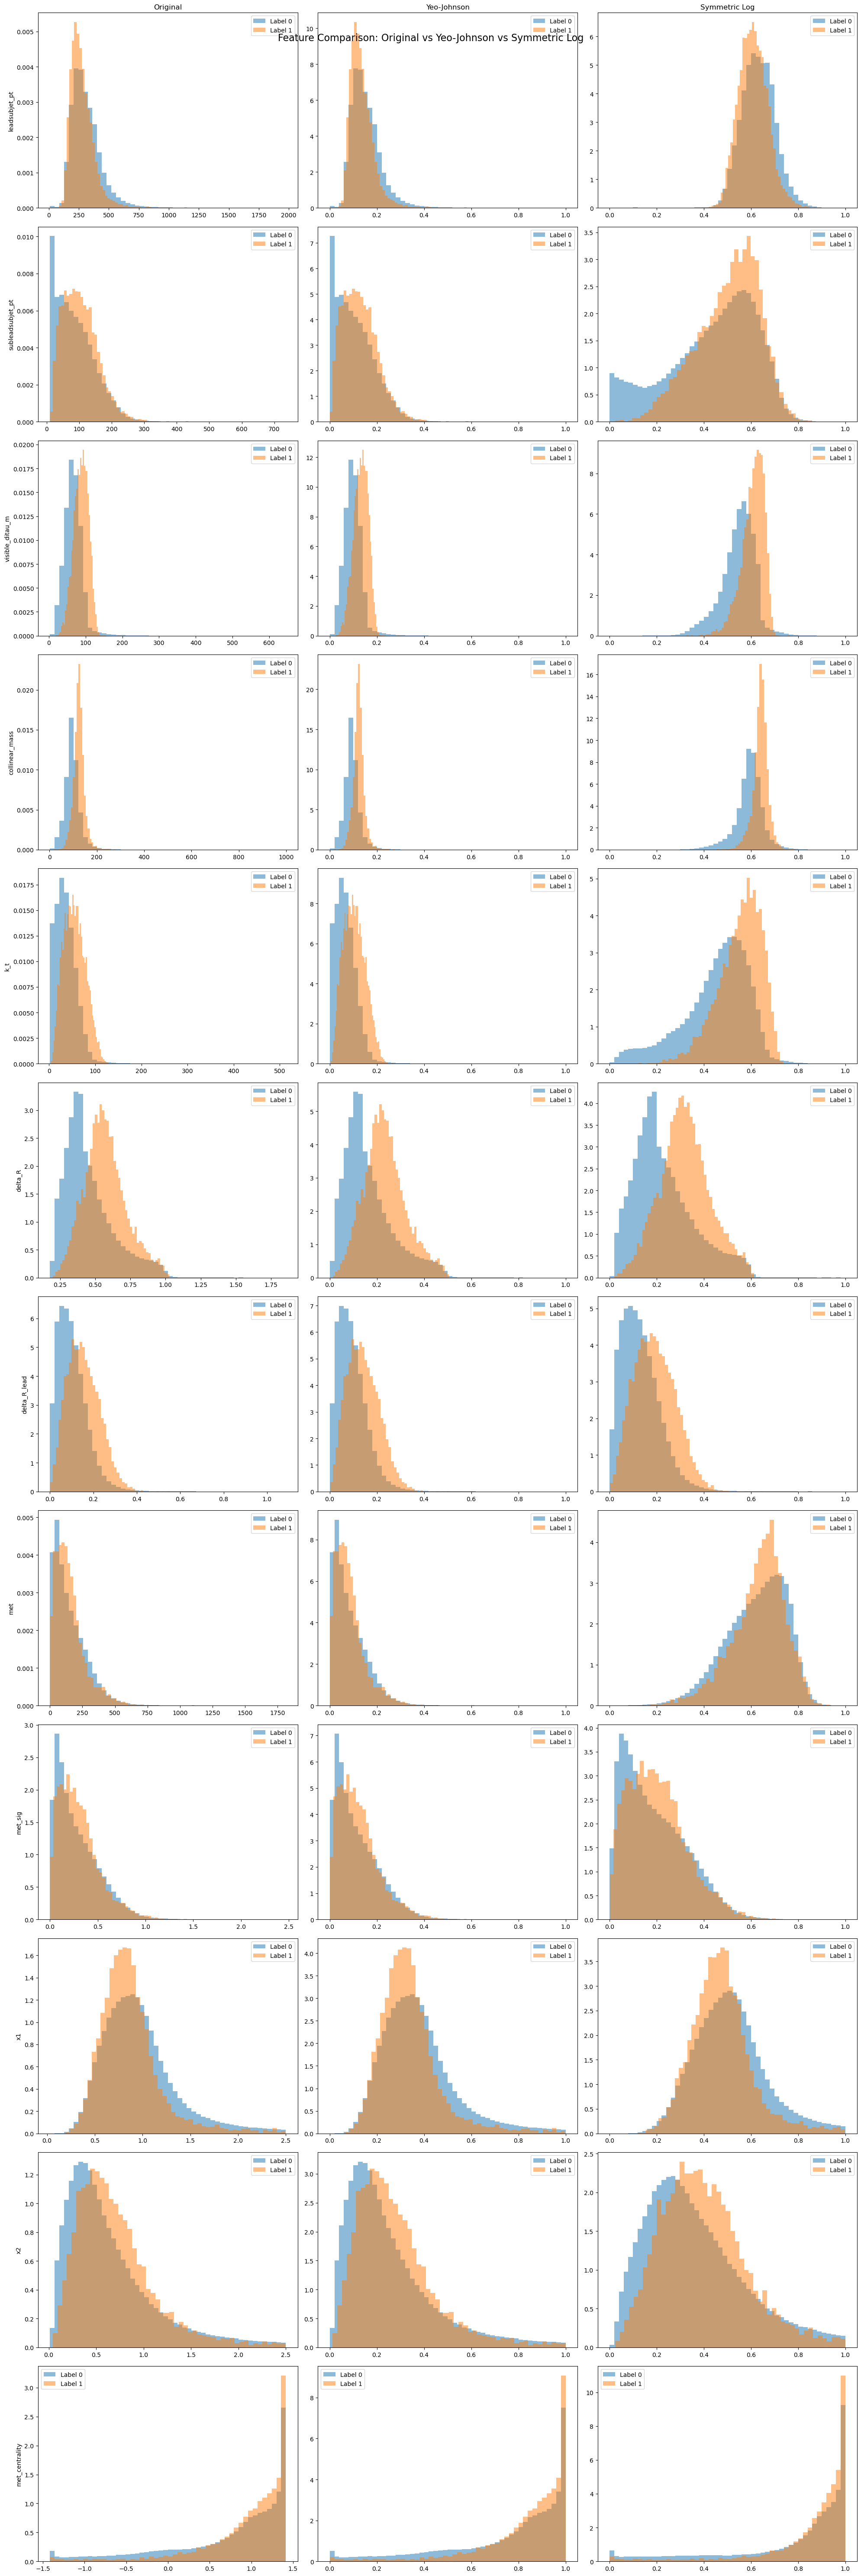

Comparison plots have been generated for original, Yeo-Johnson, and Symmetric Log transformed features.


In [48]:
def plot_feature_comparison(original, yj, symlog, labels, feature_names):
    n_features = len(feature_names)
    fig, axes = plt.subplots(n_features, 3, figsize=(20, 5*n_features))
    fig.suptitle("Feature Comparison: Original vs Yeo-Johnson vs Symmetric Log", fontsize=16)
    
    for i, feature in enumerate(feature_names):
        for j, (data, title) in enumerate(zip([original, yj, symlog], 
                                              ['Original', 'Yeo-Johnson', 'Symmetric Log'])):
            ax = axes[i, j]
            
            # Separate data for each label
            data_0 = data[labels == 0, i]
            data_1 = data[labels == 1, i]
            
            # Plot histograms
            ax.hist(data_0, bins=50, alpha=0.5, label='Label 0', density=True)
            ax.hist(data_1, bins=50, alpha=0.5, label='Label 1', density=True)
            
            if j == 0:
                ax.set_ylabel(feature)
            if i == 0:
                ax.set_title(title)
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Original data
features, labels = df[training_vars].values, df['label'].values

# Yeo-Johnson Transformation
# yj_transformer = PowerTransformer(method='yeo-johnson')
# features_yj = yj_transformer.fit_transform(features)

# 2. Min-Max Scaling
minmax_scaler = MinMaxScaler()
features_yj = minmax_scaler.fit_transform(features)

# Symmetric Log Transformation
def symlog(x, threshold=1e-5):
    return np.sign(x) * np.log1p(np.abs(x) + threshold)
features_symlog = symlog(features)

#combine minmax and symlog
features_symlog = minmax_scaler.fit_transform(features_symlog)

# Plot comparison
plot_feature_comparison(features, features_yj, features_symlog, labels, training_vars)

print("Comparison plots have been generated for original, Yeo-Johnson, and Symmetric Log transformed features.")

In [24]:
# Hyperparameters
learning_rate = 0.000064
batch_size = 256
dropout = 0
neuron1 = 64
neuron2 = 64
neuron3 = 512
neuron4 = 64
neuron5 = 0
num_epochs = 30

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'k_t',
    'delta_R', 'delta_R_lead', 'met_sig', 'x1', 'x2', 'met_centrality'
]

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, neuron1, neuron2, neuron3, neuron4, neuron5, dropout):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, neuron1),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron1, neuron2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron2, neuron3),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron3, neuron4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(neuron4, 1),
            # nn.GELU(),
            # nn.Dropout(dropout),
            # nn.Linear(neuron5, 1)
        )

    def forward(self, x):
        return self.layers(x)
    
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
model = MLP(input_size=len(training_vars), neuron1=neuron1, neuron2=neuron2, neuron3=neuron3, neuron4=neuron4, neuron5=neuron5, dropout=dropout).to(device)


Using GPU


In [25]:
# # Split the dataset into training and validation sets
# df['eventID_mod'] = df['event_number'] % 10
# train_loc = df['eventID_mod'] < 7  # 70%
# test_loc = df['eventID_mod'] >= 7  # 30%

# features, labels = df[training_vars].values, df['label'].values
# X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]
# print("len X_train:", len(X_train))
# print("len X_val:", len(X_val))

# event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]
# ff_train, ff_val = df['fake_factor'].values[train_loc], df['fake_factor'].values[test_loc]
# total_weight_train = event_weight_train*ff_train
# total_weight_val = event_weight_val*ff_val

# # Normalize features
# # scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_val_scaled = scaler.transform(X_val)
# X_train_scaled = X_train
# X_val_scaled = X_val

# # Convert data to PyTorch tensors and move to GPU if available
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
# y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
# y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)

# X_val_event_numbers = df['event_number'].values[test_loc]

# # Create DataLoader for batch training
# train_data = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [26]:
# # Calculate class weights
# n_background = np.sum(y_train == 0)
# n_signal = np.sum(y_train == 1)
# # weight_for_0 = (1 / n_background) * ((n_background + n_signal) / 2)
# # weight_for_1 = (1 / n_signal) * ((n_background + n_signal) / 2)

# # Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([n_background / n_signal]).to(device))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# # Early stopping function
# def early_stopping(val_loss_list, patience=5):
#     if len(val_loss_list) > patience:
#         if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
#             return True
#     return False

# # Training loop
# best_val_loss = float('inf')
# val_loss_list = []
# train_loss_list = []

# for epoch in range(num_epochs):
#     model.train()
#     train_loss = 0.0
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item()
    
#     avg_train_loss = train_loss / len(train_loader)
#     train_loss_list.append(avg_train_loss)
    
#     # Validation
#     model.eval()
#     with torch.no_grad():
#         val_outputs = model(X_val_tensor)
#         val_loss = criterion(val_outputs, y_val_tensor).item()
    
#     val_loss_list.append(val_loss)
#     scheduler.step(val_loss)
    
#     print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         torch.save(model.state_dict(), 'best_model.pth')
    
#     if early_stopping(val_loss_list):
#         print("Early stopping")
#         break



In [27]:
#plot all df[training_vars].values next to each other
#the

In [57]:
# Preparing the data
df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]
ff_train, ff_val = df['fake_factor'].values[train_loc], df['fake_factor'].values[test_loc]
total_weight_train = event_weight_train * ff_train
total_weight_val = event_weight_val * ff_val


minmax_scaler = MinMaxScaler()
# Symmetric Log Transformation
def symlog(x, threshold=1e-5):
    return np.sign(x) * np.log1p(np.abs(x) + threshold)

# Normalize features if needed
X_train_scaled = minmax_scaler.fit_transform(symlog(X_train))
X_val_scaled = minmax_scaler.transform(symlog(X_val))
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_val_scaled = scaler.transform(X_val)
# X_train_scaled = X_train
# X_val_scaled = X_val

print("shape of X_train_scaled: ", X_train_scaled.shape)
print("shape of X_val_scaled: ", X_val_scaled.shape)

# Convert data to PyTorch tensors and move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1).to(device)
total_weight_train_tensor = torch.tensor(total_weight_train, dtype=torch.float32).to(device)

# Create DataLoader for batch training
train_data = TensorDataset(X_train_tensor, y_train_tensor, total_weight_train_tensor)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Calculate class weights
n_background = np.sum(y_train == 0)
n_signal = np.sum(y_train == 1)
pos_weight = torch.tensor([n_background / n_signal]).to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight, reduction='none')  # Use reduction='none' to apply weights
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping function
def early_stopping(val_loss_list, patience=5):
    if len(val_loss_list) > patience:
        if all(val_loss_list[-i-1] <= val_loss_list[-i] for i in range(1, patience)):
            return True
    return False

# Training loop
best_val_loss = float('inf')
val_loss_list = []
train_loss_list = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, labels, weights in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        weighted_loss = loss * weights.view(-1, 1)  # Apply event weights
        weighted_loss = weighted_loss.mean()  # Mean the loss over the batch
        weighted_loss.backward()
        optimizer.step()
        train_loss += weighted_loss.item()
    
    avg_train_loss = train_loss / len(train_loader)
    train_loss_list.append(avg_train_loss)
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        weighted_val_loss = val_loss * torch.tensor(total_weight_val, dtype=torch.float32).to(device).view(-1, 1)
        weighted_val_loss = weighted_val_loss.mean().item()
    
    val_loss_list.append(weighted_val_loss)
    scheduler.step(weighted_val_loss)
    
    print(f'Epoch: {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {weighted_val_loss:.4f}')
    
    if weighted_val_loss < best_val_loss:
        best_val_loss = weighted_val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    
    if early_stopping(val_loss_list):
        print("Early stopping")
        break


shape of X_train_scaled:  (483570, 11)
shape of X_val_scaled:  (206598, 11)
Epoch: 1, Train Loss: 0.0054, Val Loss: 0.0048
Epoch: 2, Train Loss: 0.0048, Val Loss: 0.0045
Epoch: 3, Train Loss: 0.0046, Val Loss: 0.0043
Epoch: 4, Train Loss: 0.0044, Val Loss: 0.0042
Epoch: 5, Train Loss: 0.0042, Val Loss: 0.0040
Epoch: 6, Train Loss: 0.0041, Val Loss: 0.0039
Epoch: 7, Train Loss: 0.0040, Val Loss: 0.0037
Epoch: 8, Train Loss: 0.0038, Val Loss: 0.0037
Epoch: 9, Train Loss: 0.0038, Val Loss: 0.0036
Epoch: 10, Train Loss: 0.0037, Val Loss: 0.0036
Epoch: 11, Train Loss: 0.0037, Val Loss: 0.0036
Epoch: 12, Train Loss: 0.0037, Val Loss: 0.0036
Epoch: 13, Train Loss: 0.0037, Val Loss: 0.0036
Epoch: 14, Train Loss: 0.0036, Val Loss: 0.0035
Epoch: 15, Train Loss: 0.0036, Val Loss: 0.0036
Epoch: 16, Train Loss: 0.0036, Val Loss: 0.0035
Epoch: 17, Train Loss: 0.0036, Val Loss: 0.0035
Epoch: 18, Train Loss: 0.0036, Val Loss: 0.0035
Epoch: 19, Train Loss: 0.0036, Val Loss: 0.0038
Epoch: 20, Train Loss

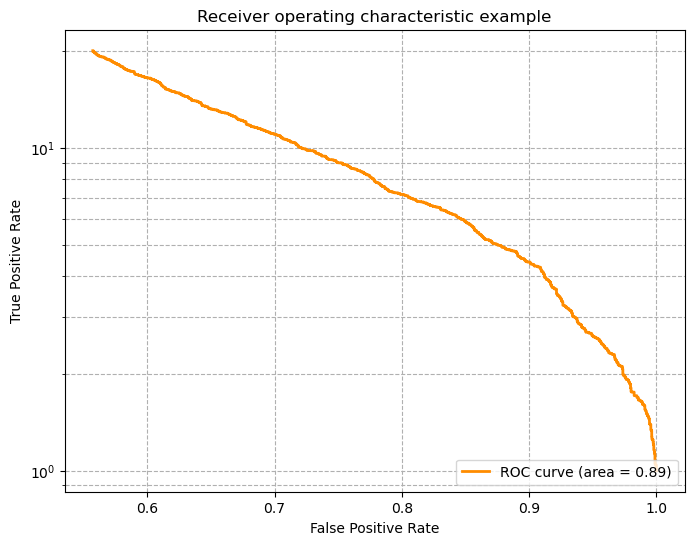

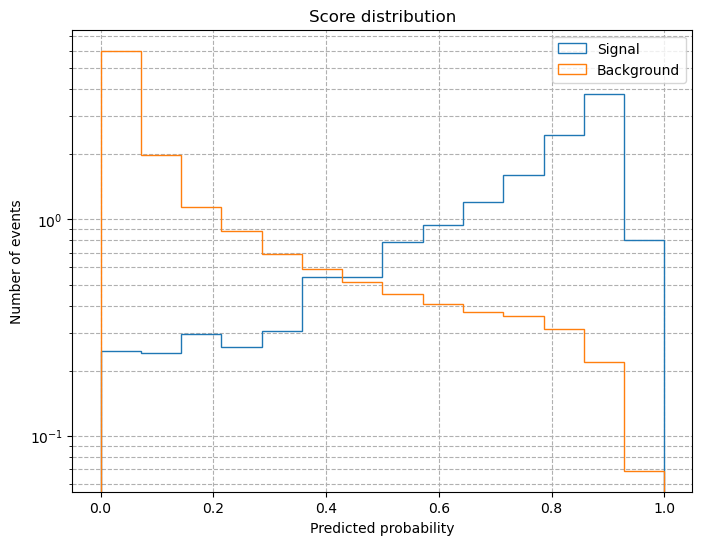

In [60]:
# load best model   
model.load_state_dict(torch.load('best_model.pth'))

# After training the model, get the predicted probabilities for the validation set
model.eval()
with torch.no_grad():
    y_val_pred = torch.sigmoid(model(X_val_tensor)).cpu().numpy().flatten()

# Compute the ROC curve and AUC
fpr, tpr, _ = roc_curve(y_val, y_val_pred, sample_weight=total_weight_val)

#select fpr bigger than 0
tpr = tpr[fpr > 0.05]
fpr = fpr[fpr > 0.05]

roc_auc = auc(fpr, tpr)


# plt.figure(figsize=(8, 6))
# plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
# plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Training and Validation Loss vs Epochs')
# plt.legend()
# plt.grid(True)
# plt.show()

# Plot the ROC curve
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(tpr, 1/fpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.yscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

# Plot the score distribution for signal and background
plt.figure(figsize=(8, 6))
plt.hist(y_val_pred[y_val == 1], bins=np.linspace(0, 1, 15), label='Signal', histtype='step', density=True)
plt.hist(y_val_pred[y_val == 0], bins=np.linspace(0, 1, 15), label='Background', histtype='step', density=True)
plt.yscale('log')
plt.xlabel('Predicted probability')
plt.ylabel('Number of events')
plt.title('Score distribution')
plt.legend(loc='upper right')
plt.grid(True, which="both", ls="--")
plt.show()


Using device: cuda
shape of X_train_scaled:  (483570, 11)
shape of X_val_scaled:  (206598, 11)
Epoch [10/30], Loss: 0.0260, Val Loss: 0.0454, Val Accuracy: 0.9871
Epoch [20/30], Loss: 0.0599, Val Loss: 0.0450, Val Accuracy: 0.9871
Epoch [30/30], Loss: 0.0316, Val Loss: 0.0435, Val Accuracy: 0.9872
Final Validation Accuracy: 0.9872


/tmp/ipykernel_1808726/3933175399.py:101: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)


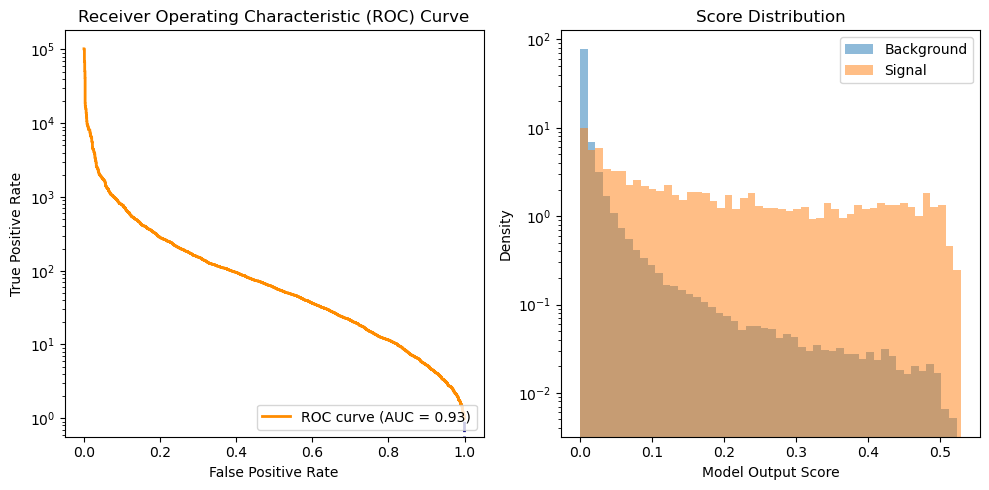

In [24]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'k_t',
    'delta_R', 'delta_R_lead', 'met_sig', 'x1', 'x2', 'met_centrality'
]

df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

minmax_scaler = MinMaxScaler()
# Symmetric Log Transformation
def symlog(x, threshold=1e-5):
    return np.sign(x) * np.log1p(np.abs(x) + threshold)
# Normalize features if needed
X_train_scaled = minmax_scaler.fit_transform(symlog(X_train))
X_val_scaled = minmax_scaler.transform(symlog(X_val))
print("shape of X_train_scaled: ", X_train_scaled.shape)
print("shape of X_val_scaled: ", X_val_scaled.shape)


# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Define the MLP model
class BinaryClassificationMLP(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Instantiate the model
input_size = X_train_scaled.shape[1]
model = BinaryClassificationMLP(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs.squeeze(), y_val_tensor)
        val_preds = (val_outputs.squeeze() > 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}')

# Final evaluation, ROC curve, and score distribution
model.eval()
with torch.no_grad():
    final_outputs = model(X_val_tensor)
    final_preds = (final_outputs.squeeze() > 0.5).float()
    final_accuracy = (final_preds == y_val_tensor).float().mean()
    print(f'Final Validation Accuracy: {final_accuracy.item():.4f}')

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_val_tensor.cpu().numpy(), final_outputs.squeeze().cpu().numpy())
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.yscale('log')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")

    # Plot score distribution
    plt.subplot(1, 2, 2)
    scores = final_outputs.squeeze().cpu().numpy()
    signal_scores = scores[y_val == 1]
    background_scores = scores[y_val == 0]
    
    plt.hist(background_scores, bins=15, alpha=0.5, density=True, label='Background')
    plt.hist(signal_scores, bins=15, alpha=0.5, density=True, label='Signal')
    plt.yscale('log')
    plt.xlabel('Model Output Score')
    plt.ylabel('Density')
    plt.title('Score Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

Using device: cuda
shape of X_train_scaled:  (483570, 11)
shape of X_val_scaled:  (206598, 11)
Epoch [3/50], Train Loss: 0.0085, Val Loss: 0.0086, Val Accuracy: 0.8459
Sample of predictions: [3.4780914e-01 3.1696259e-06 1.2559766e-03 1.0889888e-04 1.1292706e-04]
Sample of true labels: [0. 0. 0. 0. 0.]
Epoch [6/50], Train Loss: 0.0160, Val Loss: 0.0086, Val Accuracy: 0.7510
Sample of predictions: [5.1598448e-01 6.9125967e-06 2.0582411e-03 4.1472445e-05 1.6159125e-04]
Sample of true labels: [0. 0. 0. 0. 0.]
Epoch [9/50], Train Loss: 0.0052, Val Loss: 0.0078, Val Accuracy: 0.8987
Sample of predictions: [2.8617823e-01 5.9411796e-06 7.9844118e-04 1.5746449e-05 1.1481835e-04]
Sample of true labels: [0. 0. 0. 0. 0.]
Epoch [12/50], Train Loss: 0.0074, Val Loss: 0.0078, Val Accuracy: 0.8407
Sample of predictions: [4.8521176e-01 4.3431221e-05 3.8354723e-03 8.4571904e-05 4.9964053e-04]
Sample of true labels: [0. 0. 0. 0. 0.]
Epoch [15/50], Train Loss: 0.0132, Val Loss: 0.0077, Val Accuracy: 0.861

/tmp/ipykernel_1808726/3830396811.py:137: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)


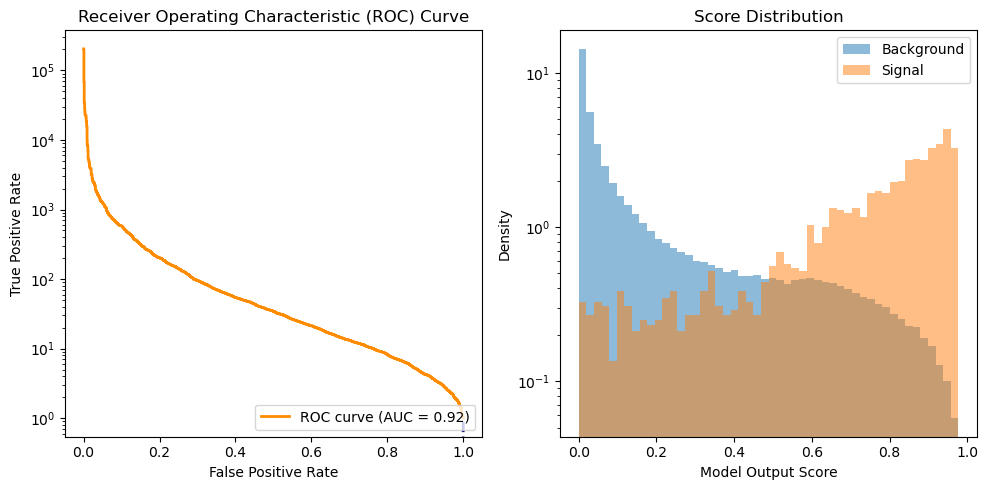

In [25]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

training_vars = [
    'leadsubjet_pt', 'subleadsubjet_pt', 'visible_ditau_m', 'collinear_mass', 'k_t',
    'delta_R', 'delta_R_lead', 'met_sig', 'x1', 'x2', 'met_centrality'
]

# Preparing the data
df['eventID_mod'] = df['event_number'] % 10
train_loc = df['eventID_mod'] < 7  # 70%
test_loc = df['eventID_mod'] >= 7  # 30%

features, labels = df[training_vars].values, df['label'].values
X_train, X_val, y_train, y_val = features[train_loc], features[test_loc], labels[train_loc], labels[test_loc]

event_weight_train, event_weight_val = df['combined_weights'].values[train_loc], df['combined_weights'].values[test_loc]
ff_train, ff_val = df['fake_factor'].values[train_loc], df['fake_factor'].values[test_loc]
total_weight_train = event_weight_train * ff_train
total_weight_val = event_weight_val * ff_val

total_weight_train = total_weight_train / np.mean(total_weight_train)
total_weight_val = total_weight_val / np.mean(total_weight_val)


minmax_scaler = MinMaxScaler()
# Symmetric Log Transformation
def symlog(x, threshold=1e-5):
    return np.sign(x) * np.log1p(np.abs(x) + threshold)

# Normalize features if needed
X_train_scaled = minmax_scaler.fit_transform(symlog(X_train))
X_val_scaled = minmax_scaler.transform(symlog(X_val))
print("shape of X_train_scaled: ", X_train_scaled.shape)
print("shape of X_val_scaled: ", X_val_scaled.shape)


# Convert numpy arrays to PyTorch tensors, including weights
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
weight_train_tensor = torch.FloatTensor(total_weight_train).to(device)
weight_val_tensor = torch.FloatTensor(total_weight_val).to(device)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor, weight_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# Calculate class weights to handle imbalance
num_samples = len(y_train)
num_classes = 2
class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in range(num_classes)])
weight = 1. / class_sample_count
class_weights = torch.FloatTensor(weight).to(device)

# Normalize class weights
class_weights = class_weights / class_weights.sum()

# Define the MLP model
class BinaryClassificationMLP(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassificationMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

# Instantiate the model
input_size = X_train_scaled.shape[1]
model = BinaryClassificationMLP(input_size).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y, batch_weights in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        epoch_loss = 0
        # Apply both sample weights and class weights
        sample_weights = batch_weights * class_weights[batch_y.long()]
        losses = criterion(outputs.squeeze(), batch_y)
        weighted_losses = losses * sample_weights
        loss = weighted_losses.mean()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_losses = criterion(val_outputs.squeeze(), y_val_tensor)
        weighted_val_losses = val_losses * weight_val_tensor * class_weights[y_val_tensor.long()]
        val_loss = weighted_val_losses.mean()
        val_preds = (val_outputs.squeeze() > 0.5).float()
        accuracy = (val_preds == y_val_tensor).float().mean()
    
    if (epoch + 1) % 3 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {accuracy.item():.4f}')

# Final evaluation, ROC curve, and score distribution
model.eval()
with torch.no_grad():
    final_outputs = model(X_val_tensor)
    final_preds = (final_outputs.squeeze() > 0.5).float()
    final_accuracy = (final_preds == y_val_tensor).float().mean()
    print(f'Final Validation Accuracy: {final_accuracy.item():.4f}')

    # Save true labels and model outputs
    np.save('true_labels_w.npy', y_val_tensor.cpu().numpy())
    np.save('model_outputs_w.npy', final_outputs.squeeze().cpu().numpy())


In [ ]:
# Load true labels and model outputs
true_labels = np.load('true_labels_w.npy')
model_outputs = np.load('model_outputs_w.npy')

# Calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(true_labels, model_outputs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(tpr, 1/fpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.yscale('log')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot score distribution
plt.subplot(1, 2, 2)
scores = model_outputs
signal_scores = scores[true_labels == 1]
background_scores = scores[true_labels == 0]

plt.hist(background_scores, bins=15, alpha=0.5, density=True, label='Background')
plt.hist(signal_scores, bins=15, alpha=0.5, density=True, label='Signal')
plt.yscale('log')
plt.xlabel('Model Output Score')
plt.ylabel('Density')
plt.title('Score Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [48]:
from multiprocessing import Pool, cpu_count
import traceback

#path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.Httbst_b6.mc20_13TeV.700793.Sh_2214_Ztt_maxHTpT_CFBV.PHYS.r13145_p5855.smPre_w_1_HS/*.root'
#path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/*.root'
path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/mc/ditau_hh/mc20e/nom/user.shhirose.*.*/user.*.root'
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores/data/ditau_hh/data18/user.shhirose.Httbst_b6.data18_13TeV.periodAllYear.physics_Main.PHYS.rp18_p18_v01_p5855.smPre_w_1_HS/*.root'
output_dir = '/global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/'

histogram_names = [
    "cutflow_muon_NOMINAL", "cutflow_ele_NOMINAL", "cutflow_pho_NOMINAL",
    "cutflow_tau_NOMINAL", "cutflow_jet_NOMINAL", "cutflow_HSM_common",
    "h_metadata", "h_metadata_theory_weights"
]

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def process_file(args):
    file_path, test_scores, event_index_map, path_template, output_dir = args
    file = None
    try:
        file = ROOT.TFile.Open(file_path, "READ")
        if not file or file.IsZombie():
            print(f"Error: Unable to open file {file_path}")
            return

        tree = file.Get("NOMINAL")
        num_entries = tree.GetEntries()
        
        relative_path = os.path.relpath(file_path, os.path.commonpath([file_path, path_template.split('*')[0]]))
        output_file_path = os.path.join(output_dir, relative_path)
        output_file_dir = os.path.dirname(output_file_path)
        os.makedirs(output_file_dir, exist_ok=True)
        
        output_file = ROOT.TFile.Open(output_file_path, "RECREATE")
        new_tree = tree.CloneTree(0)
        
        scores = array('f', [0.0])
        new_tree.Branch("mlp_scores", scores, 'mlp_scores/F')
        
        for i in range(num_entries):
            tree.GetEntry(i)
            event_number = tree.event_number
            
            if event_number in event_index_map:
                scores[0] = test_scores[event_index_map[event_number]]
            else:
                scores[0] = -1.0
            
            new_tree.Fill()
        
        new_tree.Write()

        for hist_name in histogram_names:
            hist = file.Get(hist_name)
            if hist:
                hist_clone = hist.Clone()
                hist_clone.Write()

        output_file.Close()
        print(f"File saved: {output_file_path}")
        
    except Exception as e:
        print(f"Error processing file {file_path}:")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        print(traceback.format_exc())
    finally:
        if file:
            file.Close()

# Compute scores once (make sure this is defined correctly in your actual code)
test_scores = y_val_pred

# Create a mapping from event numbers to their indices in X_val_event_numbers
event_index_map = {event_num: idx for idx, event_num in enumerate(X_val_event_numbers)}

# Gather files
mc_files = glob.glob(path_template)
data_files = glob.glob(path_template_data)
all_files = [(file, test_scores, event_index_map, path_template, output_dir) for file in mc_files + data_files]
print(f"Found {len(mc_files)} MC files and {len(data_files)} data files")

with Pool(cpu_count()) as pool:
    pool.map(process_file, all_files)


Found 313 MC files and 280 data files
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.346191.PoPy8_NNPDF30_VBFH125_ttlm15hp20.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630540._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.304014.MadPy8_3top_SM.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38631320._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630645._000001.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_2/user.shhirose.Httbst_b6.mc20_13TeV.700792.Sh_2214_Ztt_maxHTpT_BF.PHYS.r13145_p5855.smPre_w_1_HS/user.shhirose.38630645._000003.HSM_common.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/v06_mlp_scores_

In [3]:
path = "/global/u2/a/agarabag/pscratch/OmniLearn/scripts/tau/TAU/npy/"
filename = "PET_tau_8_local_layer_scale_token_baseline_classifier.weights.npy"
data = np.load(path+filename,allow_pickle=True).item()
print(data.keys())

dict_keys(['y', 'pred', 'event_id', 'weight'])


In [10]:
#fill files with omni socres 
from multiprocessing import Pool, cpu_count
import traceback

path_template = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/mc/ditau_hh/mc20*/nom/user.shhirose.*.*/user.*.root'
path_template_data = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/data/ditau_hh/data*/user.shhirose.Httbst*/*.root'
output_dir = '/global/homes/a/agarabag/pscratch/ditdau_samples/V08/with_omni/'

histogram_names = [
    "cutflow_muon_NOMINAL", "cutflow_ele_NOMINAL", "cutflow_pho_NOMINAL",
    "cutflow_tau_NOMINAL", "cutflow_jet_NOMINAL", "cutflow_HSM_common",
    "h_metadata", "h_metadata_theory_weights"
]

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

def process_file(args):
    file_path, test_scores, event_index_map, path_template, output_dir = args
    file = None
    try:
        file = ROOT.TFile.Open(file_path, "READ")
        if not file or file.IsZombie():
            print(f"Error: Unable to open file {file_path}")
            return

        tree = file.Get("NOMINAL")
        num_entries = tree.GetEntries()
        
        relative_path = os.path.relpath(file_path, os.path.commonpath([file_path, path_template.split('*')[0]]))
        output_file_path = os.path.join(output_dir, relative_path)
        output_file_dir = os.path.dirname(output_file_path)
        os.makedirs(output_file_dir, exist_ok=True)
        
        output_file = ROOT.TFile.Open(output_file_path, "RECREATE")
        new_tree = tree.CloneTree(0)
        
        scores = array('f', [0.0])
        new_tree.Branch("omni_mva_scores", scores, 'omni_mva_scores/F')
        
        for i in range(num_entries):
            tree.GetEntry(i)
            event_number = tree.event_number
            
            if event_number in event_index_map:
                scores[0] = test_scores[event_index_map[event_number]]
            else:
                scores[0] = -1.0
            
            new_tree.Fill()
        
        new_tree.Write()

        for hist_name in histogram_names:
            hist = file.Get(hist_name)
            if hist:
                hist_clone = hist.Clone()
                hist_clone.Write()

        output_file.Close()
        # print(f"File saved: {output_file_path}")
        
    except Exception as e:
        print(f"Error processing file {file_path}:")
        print(f"Error type: {type(e).__name__}")
        print(f"Error message: {str(e)}")
        print(traceback.format_exc())
    finally:
        if file:
            file.Close()

# Compute scores once (make sure this is defined correctly in your actual code)
test_scores = data['pred'][:, 1]

# Create a mapping from event numbers to their indices in X_val_event_numbers
event_index_map = {event_num: idx for idx, event_num in enumerate(data['event_id'].flatten())}

# Gather files
mc_files = glob.glob(path_template)
data_files = glob.glob(path_template_data)
all_files = [(file, test_scores, event_index_map, path_template, output_dir) for file in mc_files + data_files]
print(f"Found {len(mc_files)} MC files and {len(data_files)} data files")

with Pool(cpu_count()) as pool:
    pool.map(process_file, all_files)


Found 1039 MC files and 1176 data files
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/V08/with_omni/mc20a/nom/user.shhirose.Httbst_b8.mc20_13TeV.700605.Sh_2212_vvvv.PHYS.r13167_p6266.smPre_w_0_HS/user.shhirose.40642009._000001.HSM_boostedDiTau.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/V08/with_omni/mc20a/nom/user.shhirose.Httbst_b8.mc20_13TeV.700488.Sh_2211_WlvWqq.PHYS.r13167_p6266.smPre_w_0_HS/user.shhirose.40641915._000001.HSM_boostedDiTau.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/V08/with_omni/mc20a/nom/user.shhirose.Httbst_b8.mc20_13TeV.700488.Sh_2211_WlvWqq.PHYS.r13167_p6266.smPre_w_0_HS/user.shhirose.40641915._000002.HSM_boostedDiTau.root
File saved: /global/homes/a/agarabag/pscratch/ditdau_samples/V08/with_omni/mc20a/nom/user.shhirose.Httbst_b8.mc20_13TeV.410647.PoPy8_Wt_DR_inclusive_atop.PHYS.r13167_p6266.smPre_w_0_HS/user.shhirose.40642035._000003.HSM_boostedDiTau.root
File saved: /global/homes/a/agarabag/pscratch/

In [87]:

# Export the model
torch.onnx.export(model,               # model being run
                  X_val_tensor,                         # model input (or a tuple for multiple inputs)
                  "mva_mlp.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['X'],   # the model's input names
                  output_names = ['Y'], # the model's output names
                  dynamic_axes={'X' : {0 : 'batch_size'},    # variable length axes
                                'Y' : {0 : 'batch_size'}})

In [88]:
import onnx

onnx_model = onnx.load("mva_mlp.onnx")
onnx.checker.check_model(onnx_model)

In [94]:
import onnxruntime

torch_out = model(X_val_tensor)

ort_session = onnxruntime.InferenceSession("mva_mlp.onnx", providers=["CPUExecutionProvider"])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(X_val_tensor)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")


[array([[-4.904828 ],
       [ 3.1654897],
       [-2.3223598],
       ...,
       [-0.8264936],
       [ 1.7189206],
       [-1.1022711]], dtype=float32)]
Exported model has been tested with ONNXRuntime, and the result looks good!


In [95]:
torch_out

tensor([[-4.9048],
        [ 3.1655],
        [-2.3224],
        ...,
        [-0.8265],
        [ 1.7189],
        [-1.1023]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [63]:
sig_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 1].cpu().numpy(), 5, 0., 1., None, False)
bkg_hist_mlp = plt_to_root_hist_w(y_val_pred[y_val == 0].cpu().numpy(), 5, 0., 1., None, False)
sig_hist_mlp.Scale(1/sig_hist_mlp.Integral())
bkg_hist_mlp.Scale(1/bkg_hist_mlp.Integral())

Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: root_hist (Potential memory leak).


In [65]:

# sig_hist_mlp.ROOT.Chi2Test(bkg_hist_mlp,"WW",res)
# res = sig_hist_mlp.Chi2Test(bkg_hist_mlp, "WW P")
chi2 = bkg_hist_mlp.Chi2Test(sig_hist_mlp, "WW P")


Chi2 = 3062.806806, Prob = 0, NDF = 4, igood = 0


In [66]:
chi2

0.0